In [13]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(plyr)
library(purrr)
library(vegan)
#library(arrow)
library(parallel)
library(ComplexHeatmap)
library(ggsci)
library(tidyverse)

# Create nDEGs plot for each celltype (p <= 0.1)

In [25]:
master <- read.csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/Figure_Notebooks/Intermediate_files/master_combined_DEG_list_all_celltypes_forfigs.csv")

In [39]:
library(dplyr)
library(tidyr)

# Create all possible combinations of celltype, Direction, and type
all_combinations <- expand.grid(celltype = unique(master$celltype),
                                Direction = unique(master$Direction),
                                type = unique(master$type))

# Summarize the data
master_summary <- master %>%
  dplyr::mutate(Expression = case_when(log2FoldChange >= 0.1 & padj <= 0.1 ~ "BR2",
                                 log2FoldChange <= -0.1 & padj <= 0.1 ~ "BR1",
                                 TRUE ~ "Unchanged")) %>%
  dplyr::filter(!Expression == 'Unchanged') %>%
  dplyr::group_by(celltype, Direction, type) %>%
  dplyr::summarise(count = n(), .groups = 'drop')

# Left join with all_combinations and fill missing counts with 0
master_complete <- left_join(all_combinations, master_summary, by = c("celltype", "Direction", "type")) %>%
  dplyr::mutate(count = replace_na(count, 0)) %>% 
  filter(!is.na(Direction)) # Remove rows with NA in the Direction column



# Check the number of unique celltypes
length(unique(master_complete$celltype))


head(master_complete)
#all_combinations


[1] 71

,celltype,Direction,type,count
,<chr>,<chr>,<chr>,<int>
1,Activated memory B cell,BR1,DEGs_Male,0
2,Adaptive NK cell,BR1,DEGs_Male,0
3,ASDC,BR1,DEGs_Male,0
4,BaEoMaP cell,BR1,DEGs_Male,0
5,C1Q+ CD16 monocyte,BR1,DEGs_Male,1
6,CD14+ cDC2,BR1,DEGs_Male,0


In [27]:
dim(master_complete)

[1] 284   4

In [83]:
# master_complete_1 <- master_complete %>% filter(celltype == "ASDC")
# master_complete_1

celltype,Direction,type,count
<chr>,<chr>,<chr>,<int>
ASDC,BR1,DEGs_Male,0
ASDC,BR2,DEGs_Male,0
ASDC,BR1,DEGs_Female,0
ASDC,BR2,DEGs_Female,0


In [ ]:
## old method
# library(dplyr)
# library(tidyr)

# master<- master%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "BR2",
#                                                      log2FoldChange <= -0.1 & padj <= 0.1 ~ "BR1",
#                                                      TRUE ~ "Unchanged"))

# master<-master %>% filter(Year=='Y1')



# master_2 <- master %>%
#   dplyr::mutate(Expression = case_when(log2FoldChange >= 0.1 & padj <= 0.1 ~ "BR2",
#                                  log2FoldChange <= -0.1 & padj <= 0.1 ~ "BR1",
#                                  TRUE ~ "Unchanged")) %>%
#   dplyr::filter(!Expression == 'Unchanged') %>%
#   dplyr::group_by(celltype, Direction, type) %>%
#   dplyr::summarise(count = n(), .groups = 'drop') %>%
#   tidyr::complete(celltype, Direction, type, fill = list(count = 0)) # Add missing combinations and fill with 0 

# head(master_2) 
# length(unique(master_2$celltype))  ## Only 38/71 celltypes had significant DEGs (p<=0.1)

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


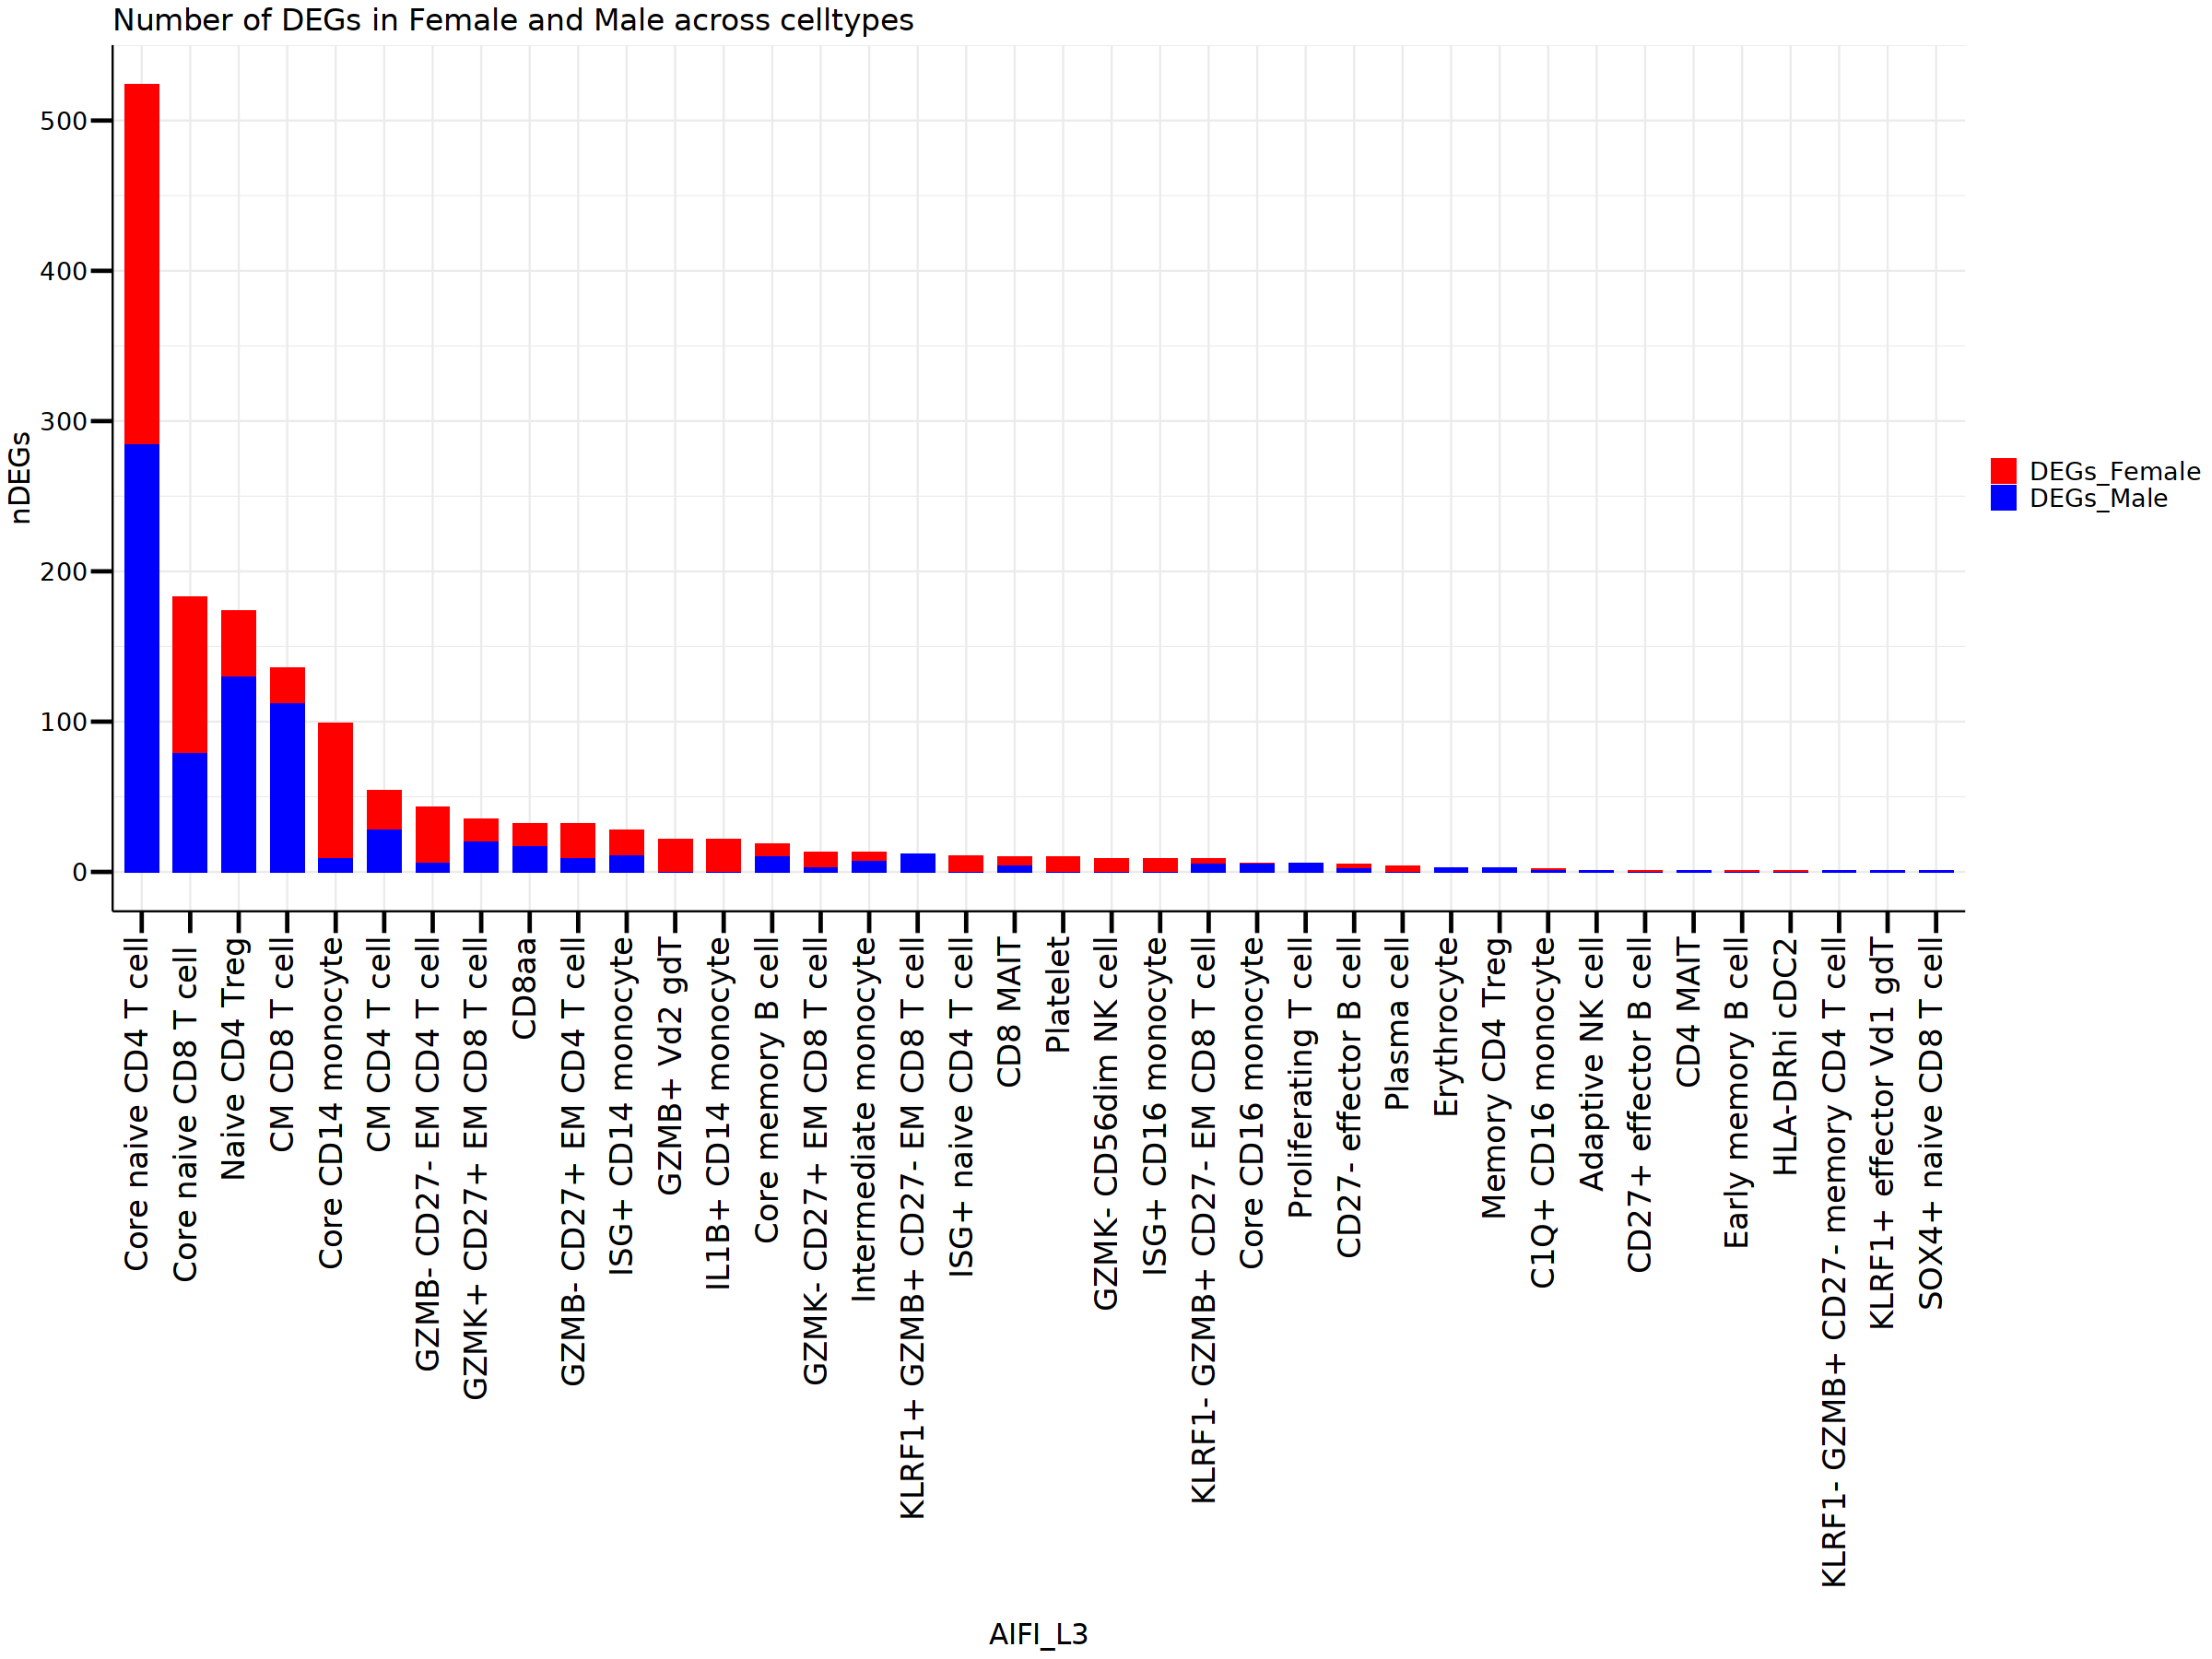

In [26]:
## stacked plot of nDEG counts

pastel_colors <- c( "red", "blue" )  # Example pastel colors


options(repr.plot.width = 20, repr.plot.height = 15)

ggplot(master_2, aes(x = reorder(celltype, desc(count)), y = count, fill = type)) +
  geom_bar(stat = "identity", width = 0.7) +
  scale_fill_manual(values = pastel_colors) +  # Set pastel colors
  labs(title = "Number of DEGs in Female and Male across celltypes", x = "\nAIFI_L3", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  ) 

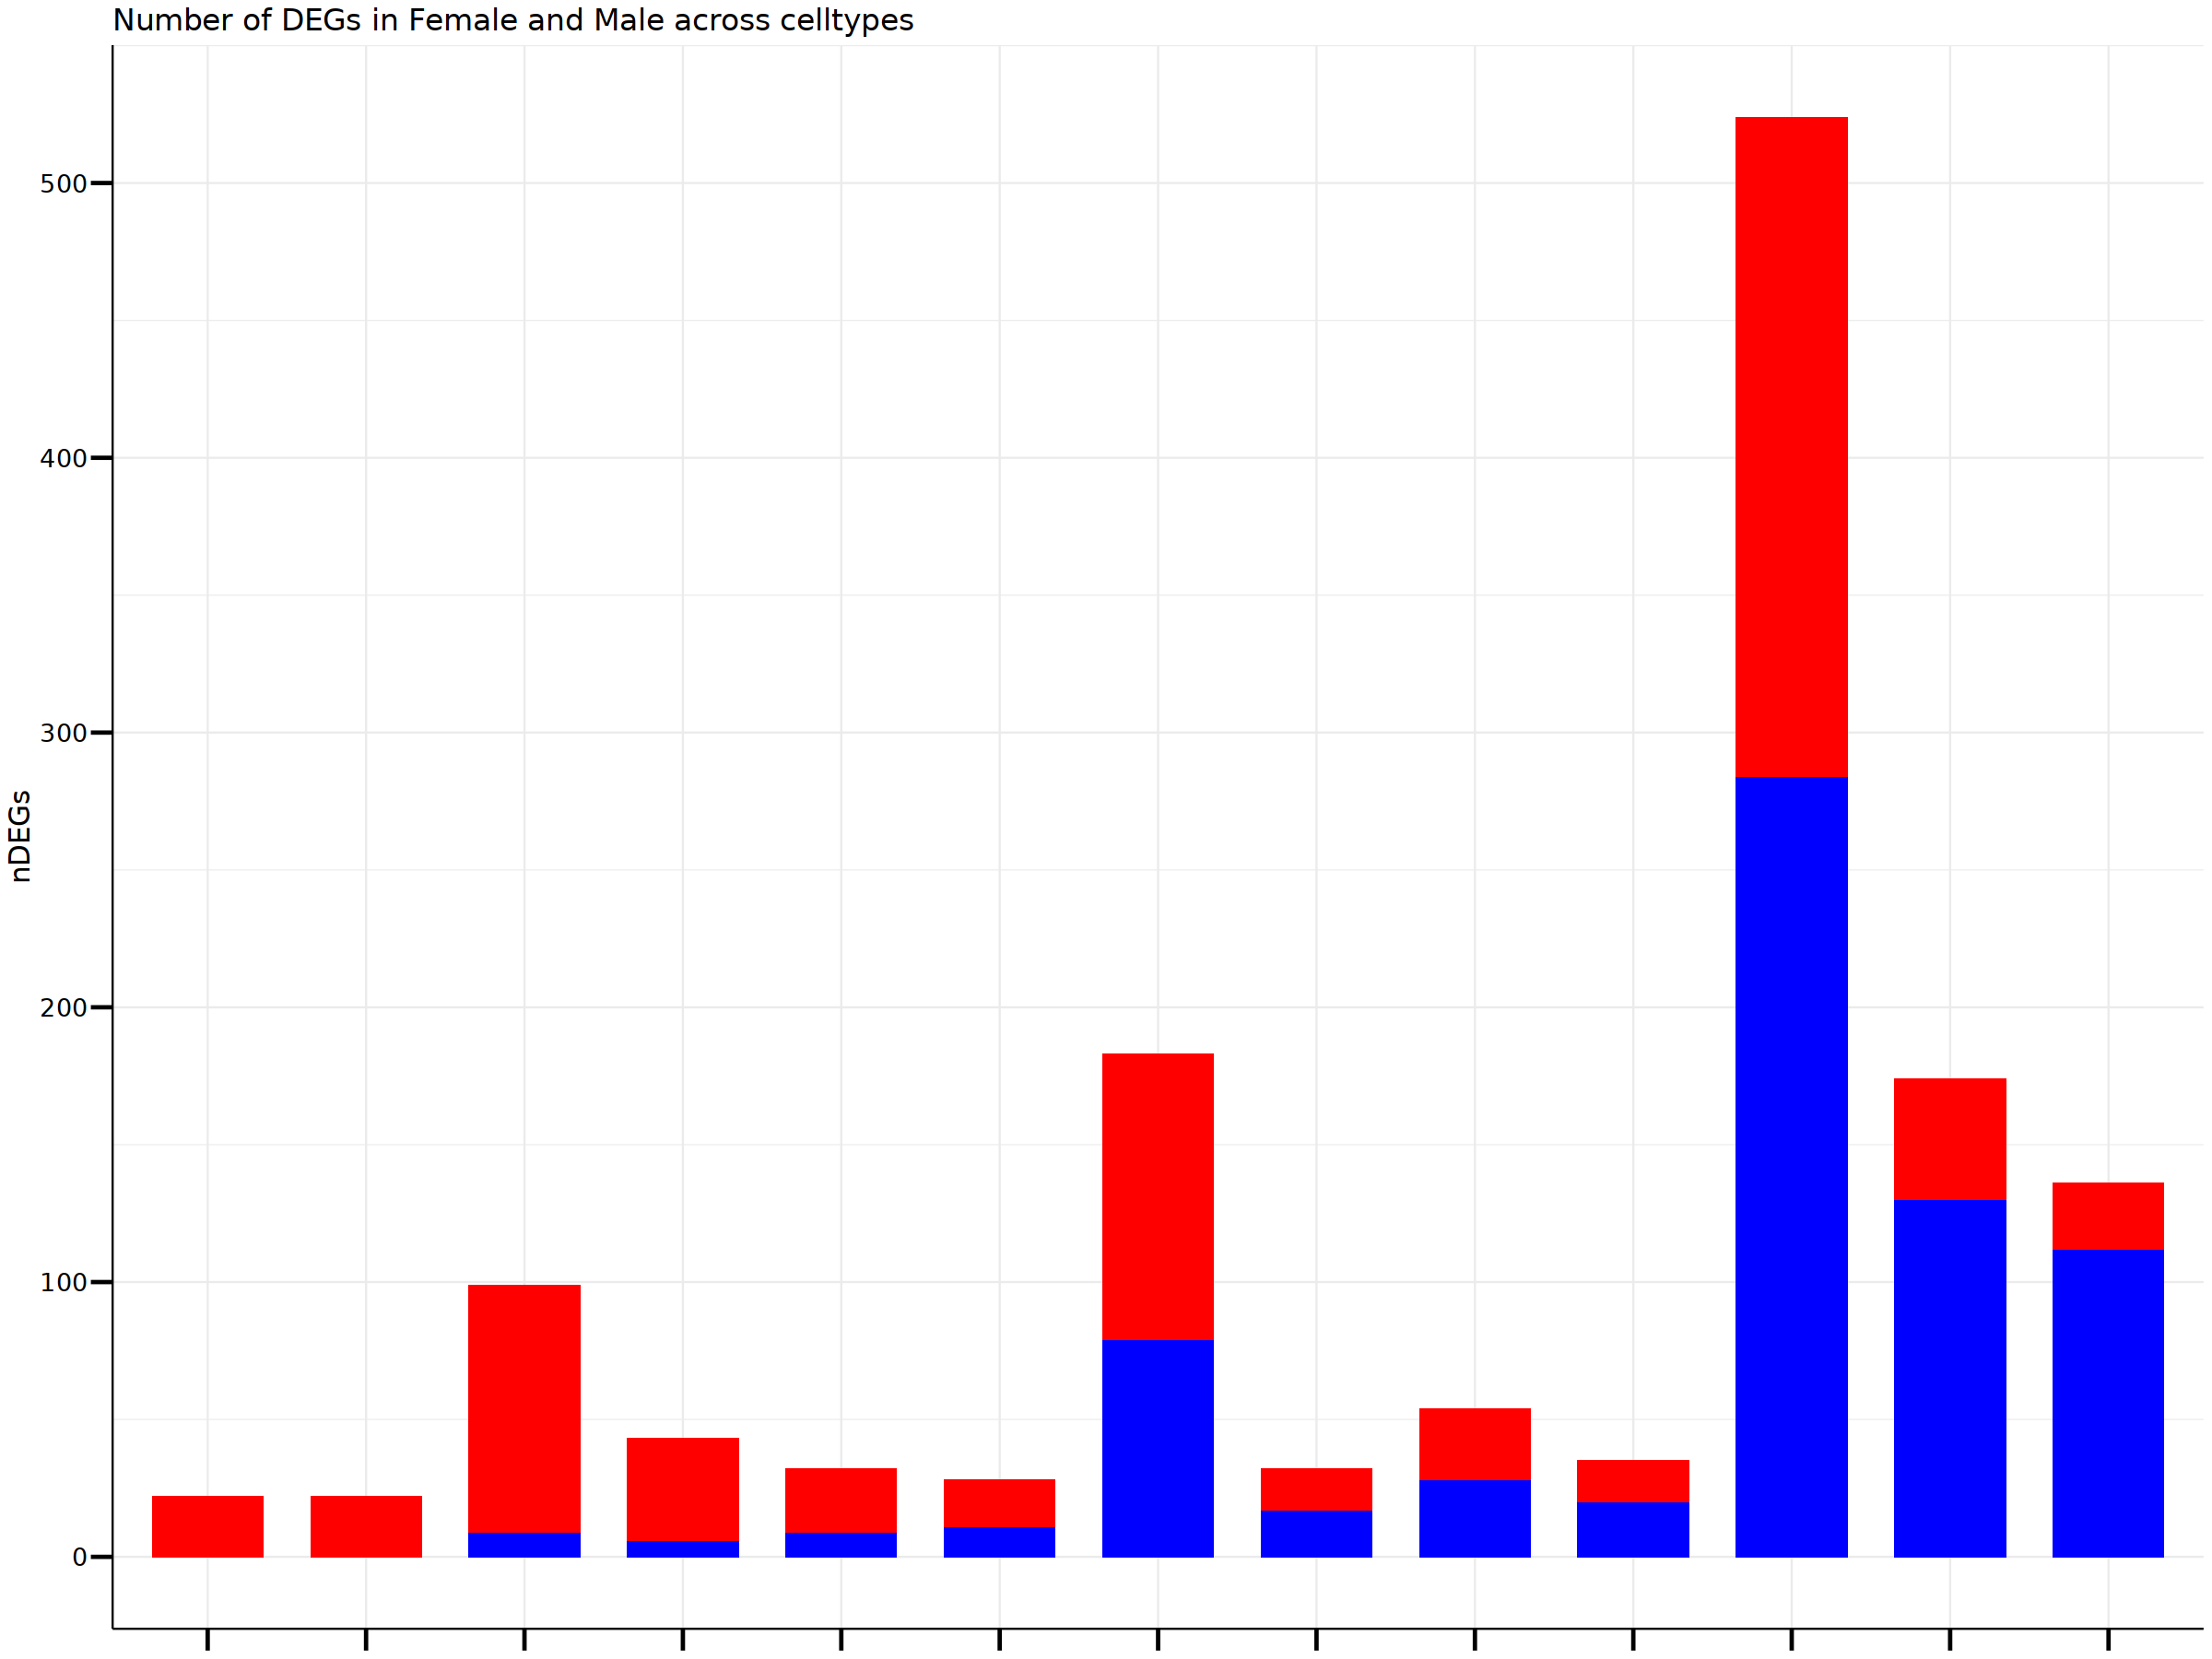

In [70]:
pastel_colors <- c( "red", "blue" )  # Example pastel colors

#celltype order from the JI plot
master_complete$celltype <- factor(master_complete$celltype, levels = celltype_order)

# Remove rows with NA values in the 'celltype' column
master_complete <- master_complete[complete.cases(master_complete$celltype), ]


#reorder(celltype, desc(count))
#options(repr.plot.width = 20, repr.plot.height = 5)

nDEG_plot <- ggplot(master_complete, aes(x = celltype, y = count, fill = type)) +
  geom_bar(stat = "identity", width = 0.7) +
  scale_fill_manual(values = pastel_colors) +  # Set pastel colors
  labs(title = "Number of DEGs in Female and Male across celltypes", x = "\nAIFI_L3", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  ) +
  theme(axis.title.x = element_blank(), axis.text.x = element_blank()) + theme(legend.position = "none")

nDEG_plot

In [67]:
master_complete$celltype

[1] <NA>                      <NA>                     
  [3] <NA>                      <NA>                     
  [5] <NA>                      <NA>                     
  [7] <NA>                      <NA>                     
  [9] <NA>                      <NA>                     
 [11] <NA>                      CD8aa                    
 [13] <NA>                      <NA>                     
 [15] <NA>                      CM CD4 T cell            
 [17] CM CD8 T cell             <NA>                     
 [19] Core CD14 monocyte        <NA>                     
 [21] <NA>                      <NA>                     
 [23] Core naive CD4 T cell     Core naive CD8 T cell    
 [25] <NA>                      <NA>                     
 [27] <NA>                      GZMB- CD27- EM CD4 T cell
 [29] GZMB- CD27+ EM CD4 T cell GZMB+ Vd2 gdT            
 [31] <NA>                      <NA>                     
 [33] GZMK+ CD27+ EM CD8 T cell <NA>                     
 [35] <NA>                      <NA>                     
 [37] <NA>                      IL1B+ CD14 monocyte      
 [39] <NA>                      <NA>                     
 [41] ISG+ CD14 monocyte        <NA>                     
 [43] <NA>                      <NA>                     
 [45] <NA>                      <NA>                     
 [47] <NA>                      <NA>                     
 [49] <NA>                      <NA>                     
 [51] <NA>                      <NA>                     
 [53] <NA>                      <NA>                     
 [55] <NA>                      <NA>                     
 [57] <NA>                      <NA>                     
 [59] <NA>                      Naive CD4 Treg           
 [61] <NA>                      <NA>                     
 [63] <NA>                      <NA>                     
 [65] <NA>                      <NA>                     
 [67] <NA>                      <NA>                     
 [69] <NA>                      <NA>                     
 [71] <NA>                      <NA>                     
 [73] <NA>                      <NA>                     
 [75] <NA>                      <NA>                     
 [77] <NA>                      <NA>                     
 [79] <NA>                      <NA>                     
 [81] <NA>                      <NA>                     
 [83] CD8aa                     <NA>                     
 [85] <NA>                      <NA>                     
 [87] CM CD4 T cell             CM CD8 T cell            
 [89] <NA>                      Core CD14 monocyte       
 [91] <NA>                      <NA>                     
 [93] <NA>                      Core naive CD4 T cell    
 [95] Core naive CD8 T cell     <NA>                     
 [97] <NA>                      <NA>                     
 [99] GZMB- CD27- EM CD4 T cell GZMB- CD27+ EM CD4 T cell
[101] GZMB+ Vd2 gdT             <NA>                     
[103] <NA>                      GZMK+ CD27+ EM CD8 T cell
[105] <NA>                      <NA>                     
[107] <NA>                      <NA>                     
[109] IL1B+ CD14 monocyte       <NA>                     
[111] <NA>                      ISG+ CD14 monocyte       
[113] <NA>                      <NA>                     
[115] <NA>                      <NA>                     
[117] <NA>                      <NA>                     
[119] <NA>                      <NA>                     
[121] <NA>                      <NA>                     
[123] <NA>                      <NA>                     
[125] <NA>                      <NA>                     
[127] <NA>                      <NA>                     
[129] <NA>                      <NA>                     
[131] Naive CD4 Treg            <NA>                     
[133] <NA>                      <NA>                     
[135] <NA>                      <NA>                     
[137] <NA>                      <NA>                     


# Create nDEGs plot for each celltype (p <= 0.05)

In [87]:
master <- read.csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/Figure_Notebooks/Intermediate_files/master_combined_DEG_list_all_celltypes_forfigs.csv")

In [88]:
library(dplyr)
library(tidyr)

# Create all possible combinations of celltype, Direction, and type
all_combinations <- expand.grid(celltype = unique(master$celltype),
                                Direction = unique(master$Direction),
                                type = unique(master$type))

# Summarize the data
master_summary <- master %>%
  dplyr::mutate(Expression = case_when(log2FoldChange >= 0.1 & padj <= 0.05 ~ "BR2",
                                 log2FoldChange <= -0.1 & padj <= 0.05 ~ "BR1",
                                 TRUE ~ "Unchanged")) %>%
  dplyr::filter(!Expression == 'Unchanged') %>%
  dplyr::group_by(celltype, Direction, type) %>%
  dplyr::summarise(count = n(), .groups = 'drop')

# Left join with all_combinations and fill missing counts with 0
master_complete <- left_join(all_combinations, master_summary, by = c("celltype", "Direction", "type")) %>%
  dplyr::mutate(count = replace_na(count, 0)) %>% 
  filter(!is.na(Direction)) # Remove rows with NA in the Direction column



# Check the number of unique celltypes
length(unique(master_complete$celltype))


head(master_complete)
#all_combinations

[1] 71

,celltype,Direction,type,count
,<chr>,<chr>,<chr>,<int>
1,Activated memory B cell,BR1,DEGs_Male,0
2,Adaptive NK cell,BR1,DEGs_Male,0
3,ASDC,BR1,DEGs_Male,0
4,BaEoMaP cell,BR1,DEGs_Male,0
5,C1Q+ CD16 monocyte,BR1,DEGs_Male,0
6,CD14+ cDC2,BR1,DEGs_Male,0


In [89]:
master_complete_1 <- master_complete %>% filter(celltype == "ASDC")
master_complete_1

celltype,Direction,type,count
<chr>,<chr>,<chr>,<int>
ASDC,BR1,DEGs_Male,0
ASDC,BR2,DEGs_Male,0
ASDC,BR1,DEGs_Female,0
ASDC,BR2,DEGs_Female,0


In [92]:
## old method
library(dplyr)
library(tidyr)

master<- master%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.05 ~ "BR2",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "BR1",
                                                     TRUE ~ "Unchanged"))

master<-master %>% filter(Year=='Y1')



master_2 <- master %>%
  dplyr::mutate(Expression = case_when(log2FoldChange >= 0.1 & padj <=0.05 ~ "BR2",
                                 log2FoldChange <= -0.1 & padj <= 0.05~ "BR1",
                                 TRUE ~ "Unchanged")) %>%
  dplyr::filter(!Expression == 'Unchanged') %>%
  dplyr::group_by(celltype, Direction, type) %>%
  dplyr::summarise(count = n(), .groups = 'drop') %>%
  tidyr::complete(celltype, Direction, type, fill = list(count = 0)) # Add missing combinations and fill with 0 

head(master_2) 
length(unique(master_2$celltype))  ## Only 38/71 celltypes had significant DEGs (p<=0.1)

celltype,Direction,type,count
<chr>,<chr>,<chr>,<int>
CD27- effector B cell,BR1,DEGs_Female,2
CD27- effector B cell,BR1,DEGs_Male,0
CD27- effector B cell,BR2,DEGs_Female,0
CD27- effector B cell,BR2,DEGs_Male,0
CD27+ effector B cell,BR1,DEGs_Female,0
CD27+ effector B cell,BR1,DEGs_Male,0


[1] 32

In [3]:
## stacked plot of nDEG counts

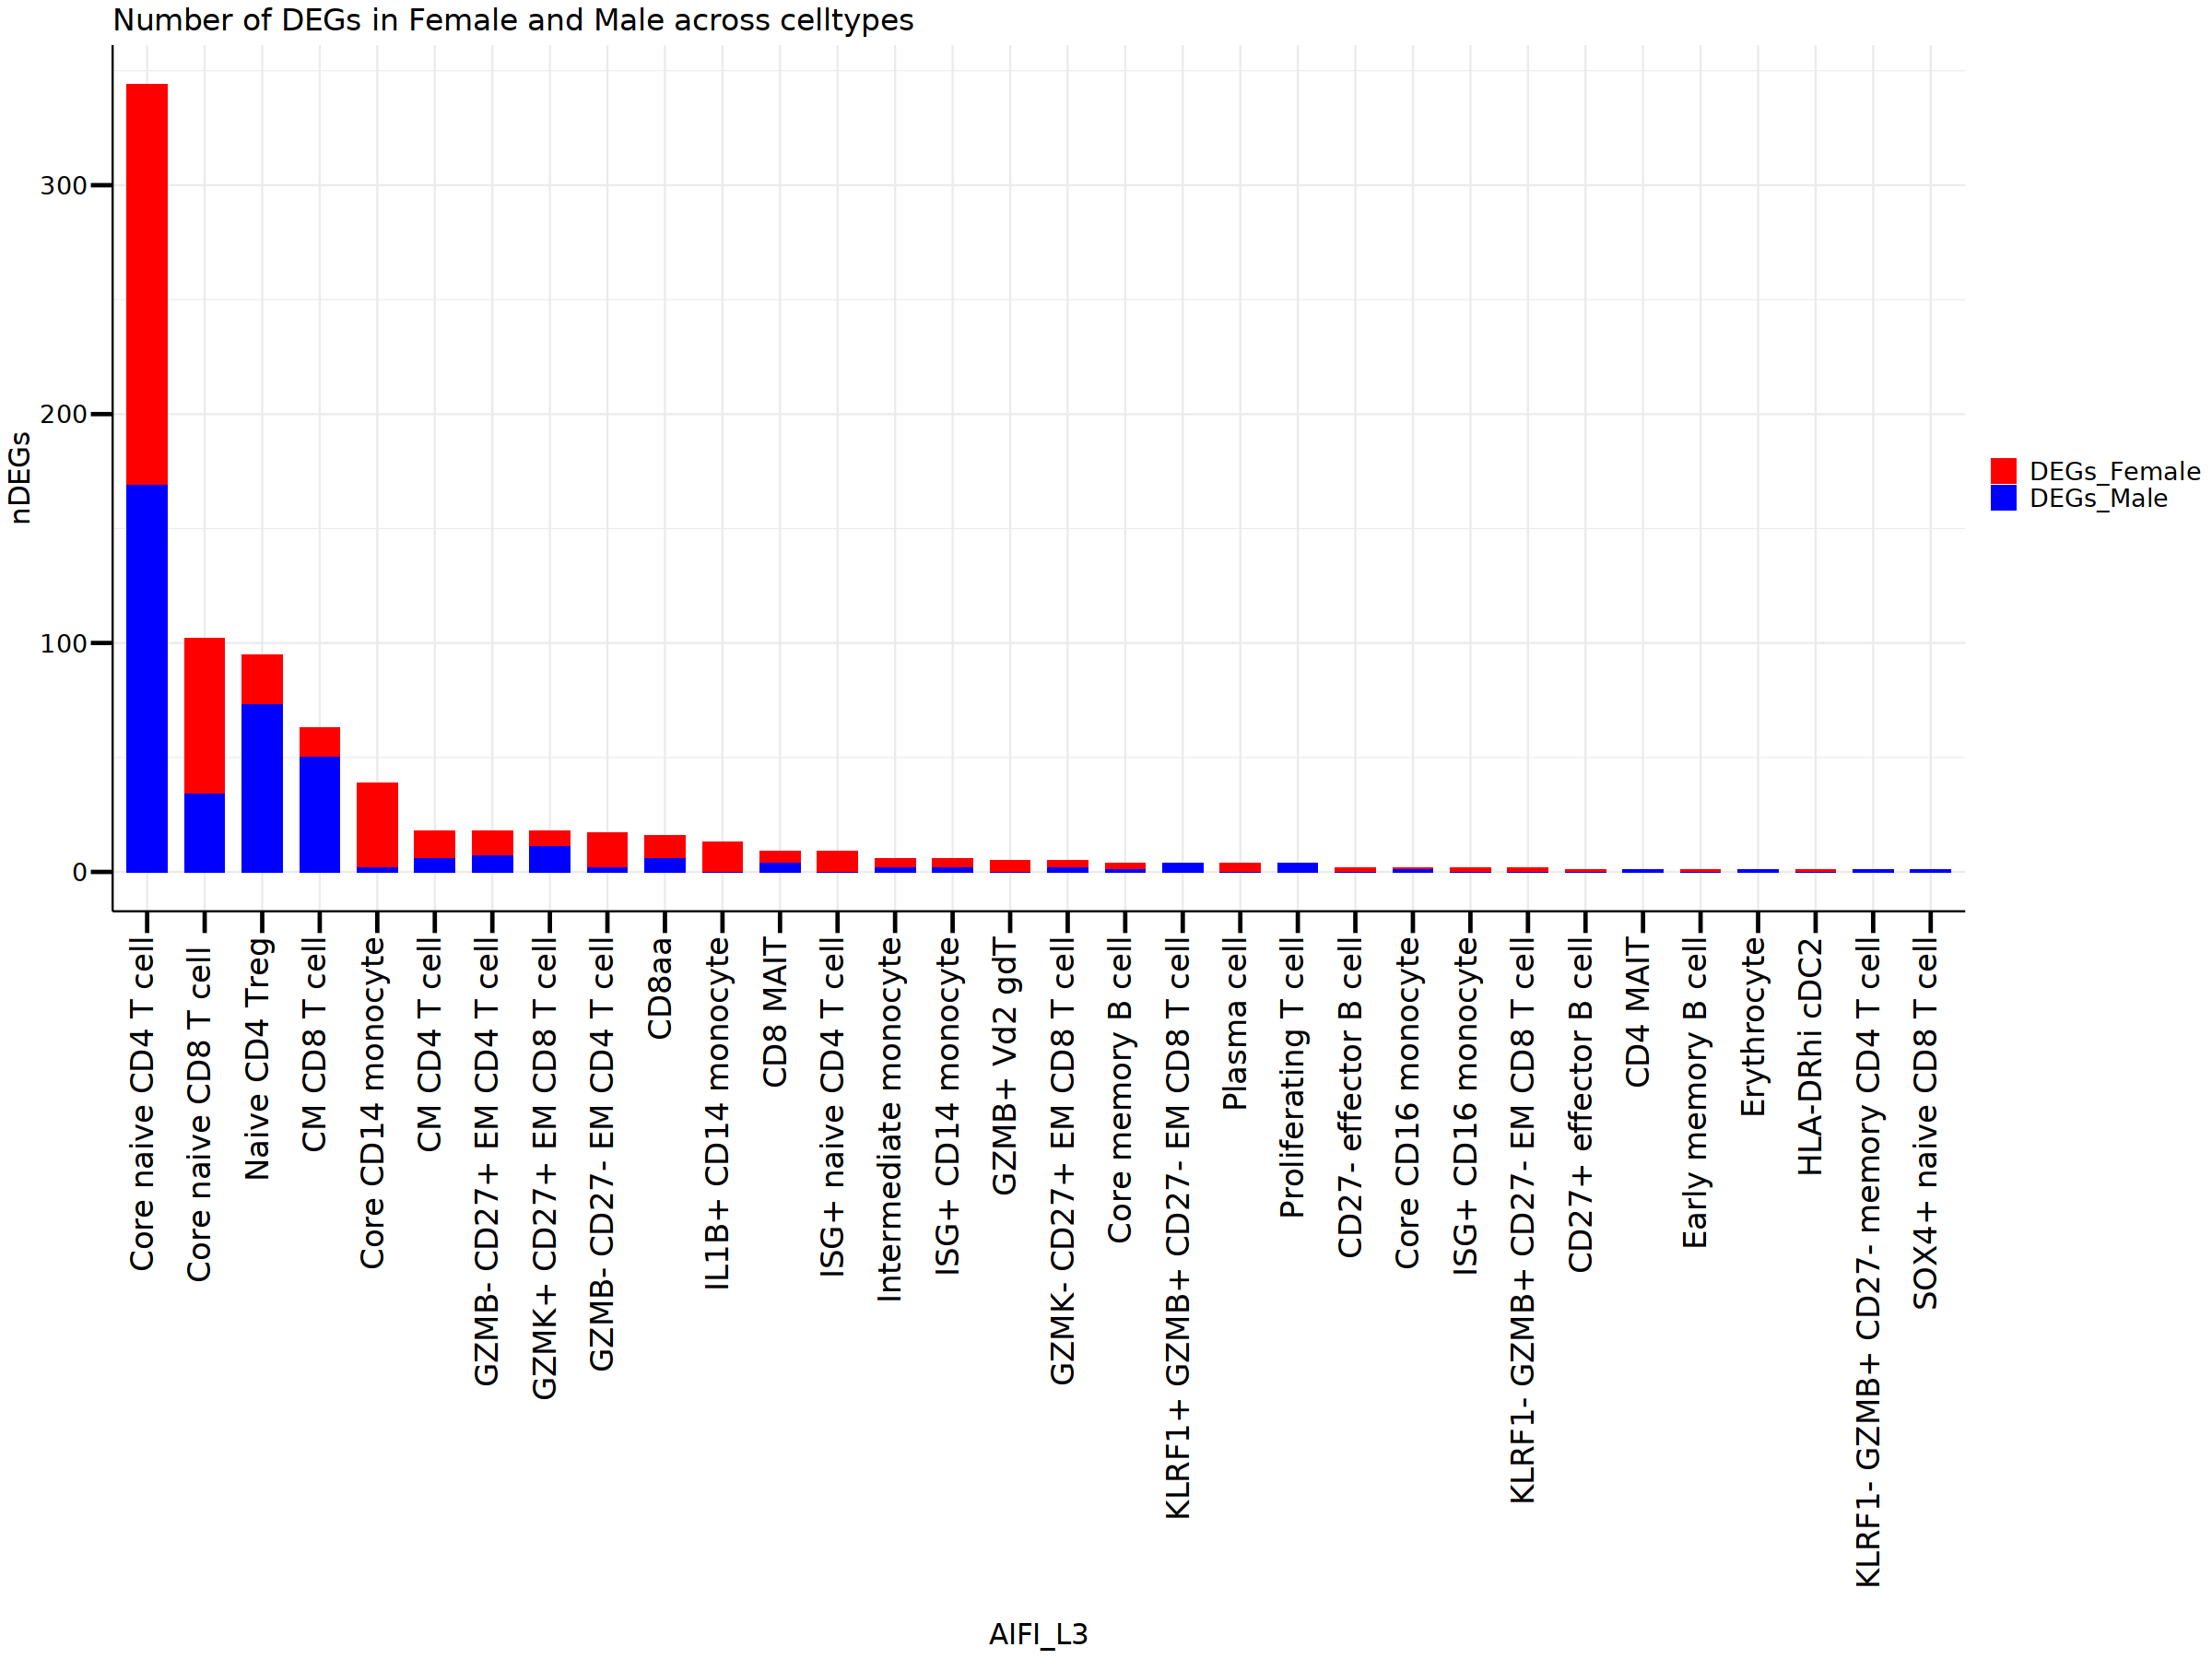

In [93]:
pastel_colors <- c( "red", "blue" )  # Example pastel colors


options(repr.plot.width = 20, repr.plot.height = 15)

ggplot(master_2, aes(x = reorder(celltype, desc(count)), y = count, fill = type)) +
  geom_bar(stat = "identity", width = 0.7) +
  scale_fill_manual(values = pastel_colors) +  # Set pastel colors
  labs(title = "Number of DEGs in Female and Male across celltypes", x = "\nAIFI_L3", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  ) 

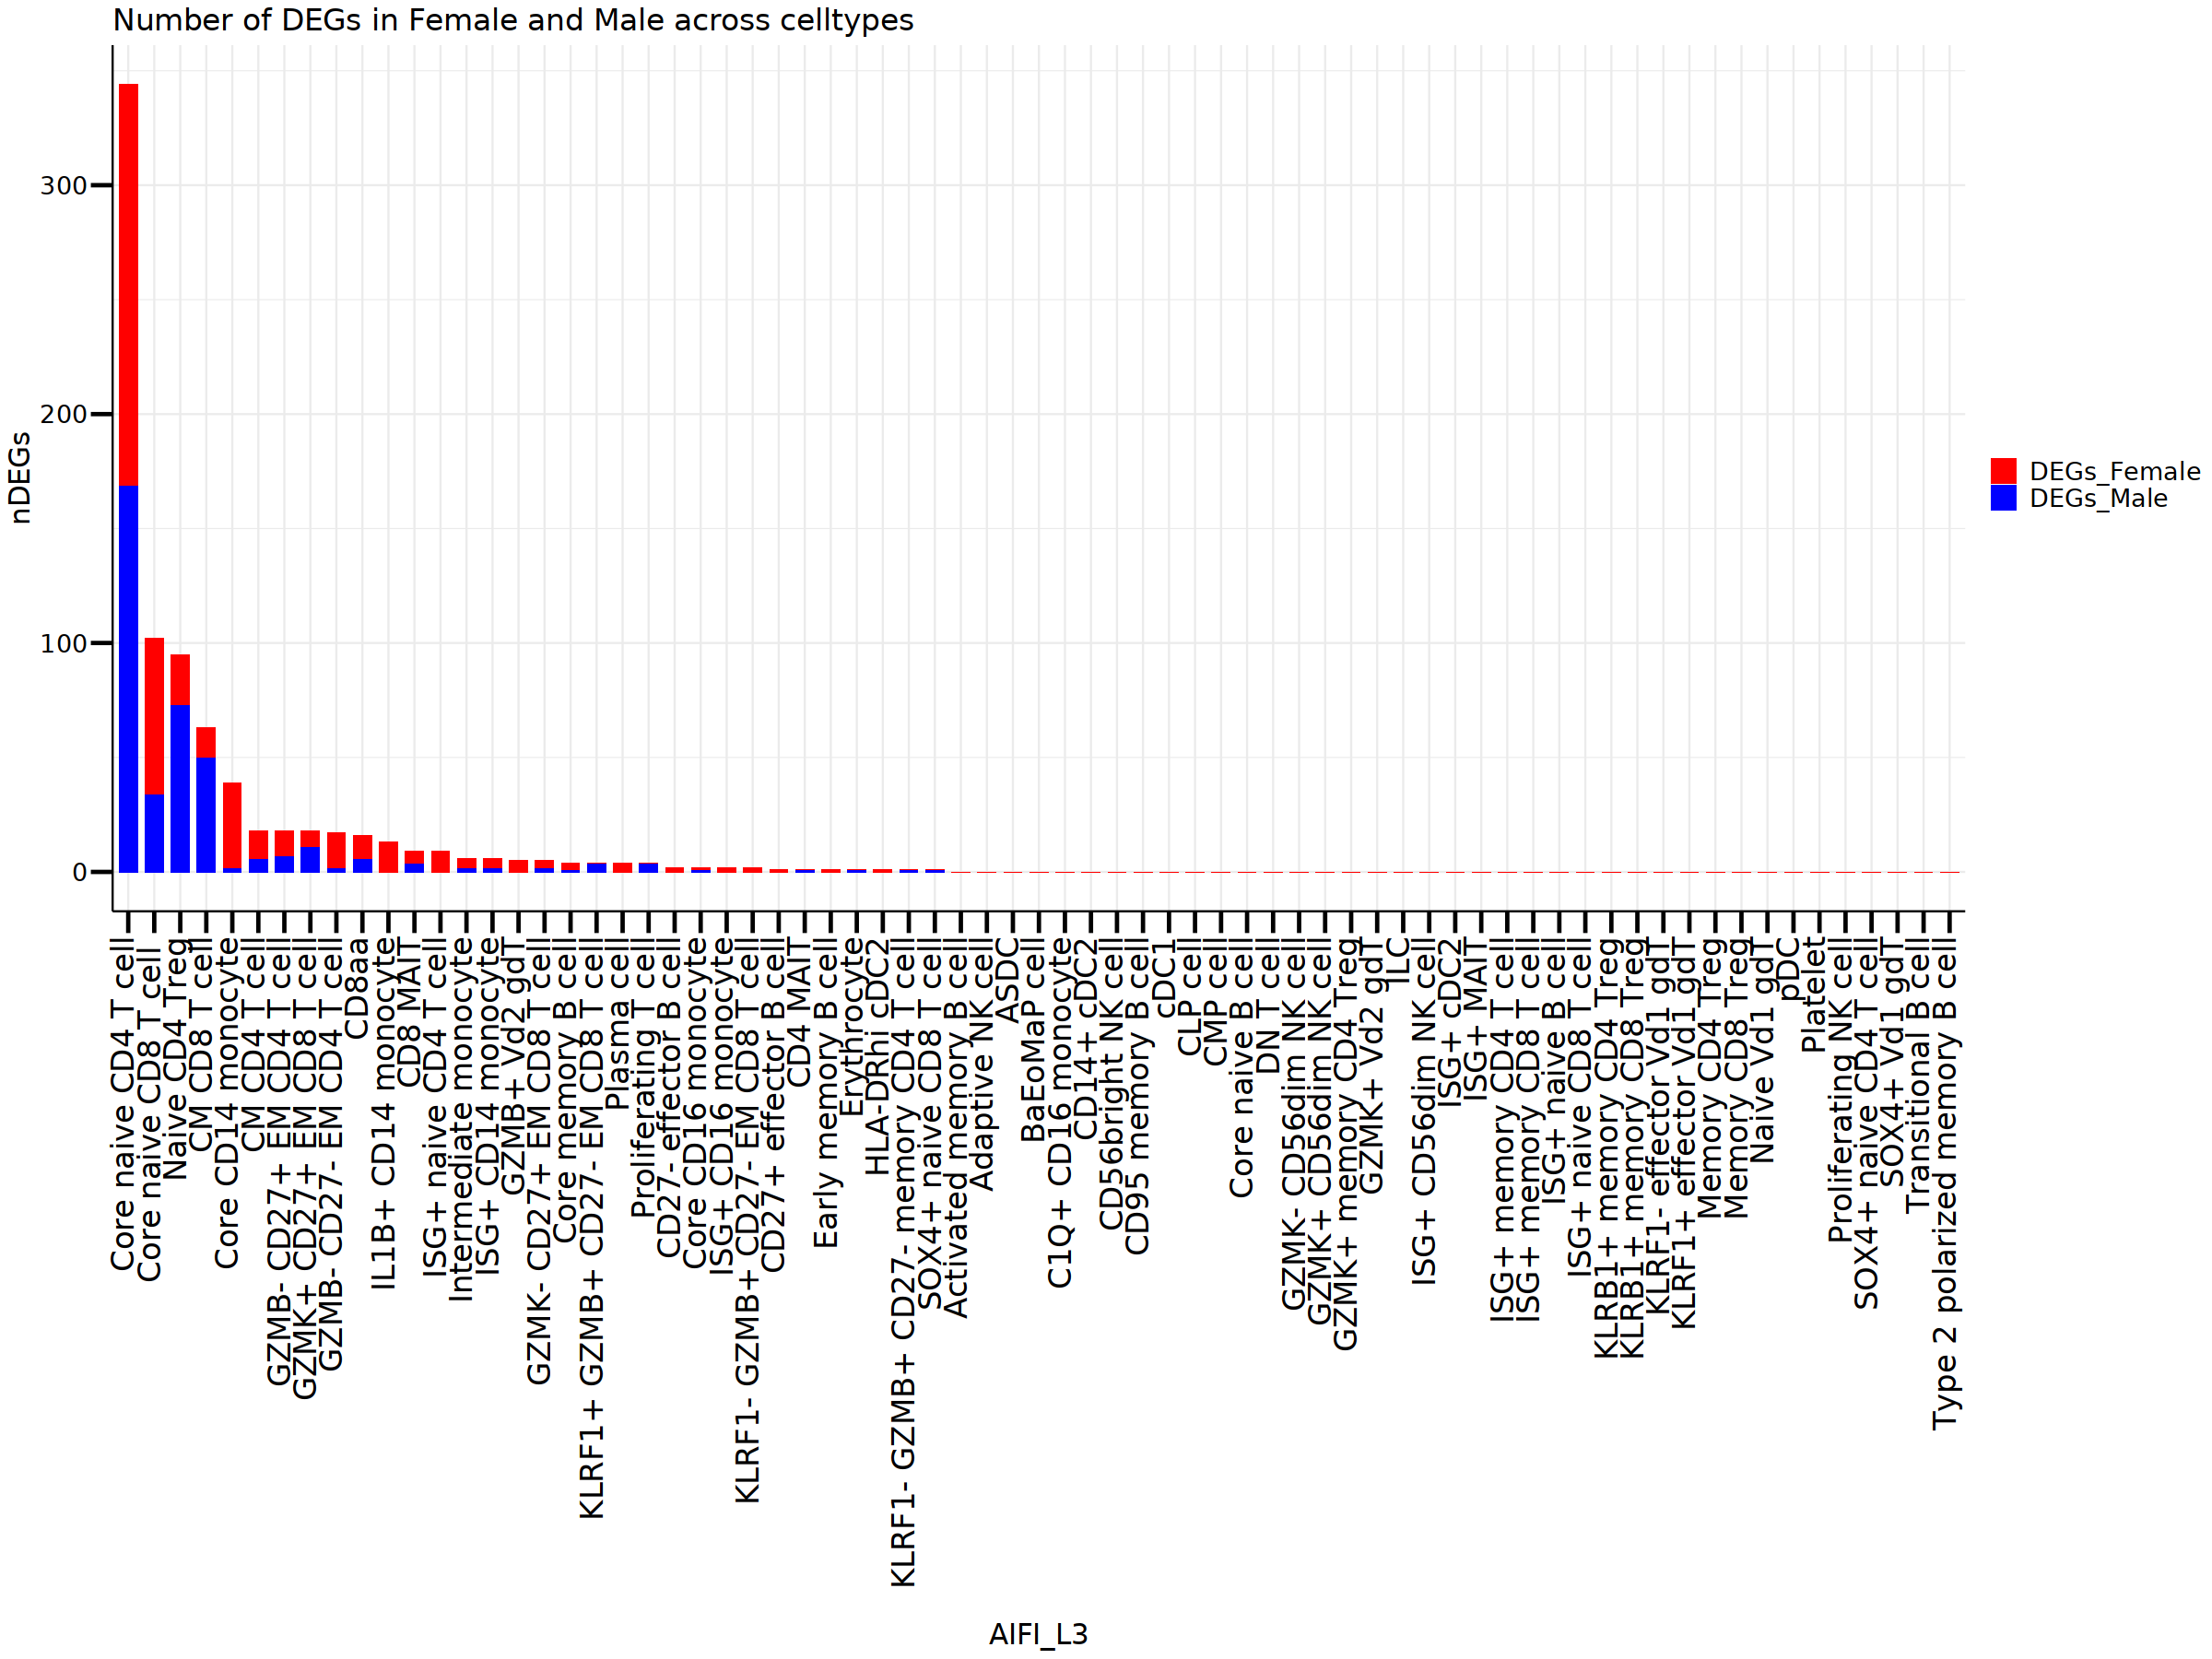

In [94]:
pastel_colors <- c( "red", "blue" )  # Example pastel colors


options(repr.plot.width = 20, repr.plot.height = 15)

ggplot(master_complete, aes(x = reorder(celltype, desc(count)), y = count, fill = type)) +
  geom_bar(stat = "identity", width = 0.7) +
  scale_fill_manual(values = pastel_colors) +  # Set pastel colors
  labs(title = "Number of DEGs in Female and Male across celltypes", x = "\nAIFI_L3", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  ) 

# Create the ratio plot using JI file (padj <0.1)

In [15]:
J_index <- read.csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/Figure_Notebooks/Intermediate_files/Jaccard_index/Jaccard_index_df_FvsM_each_celltype_padj0.01.csv")

In [16]:
#J_index

In [17]:
#Use DEG# in female/ DEG# (Female+Male-shared) on Y-axis and rank from high to low 
#     in X-axis in cell types that  have total DEGs # (f+M-s) > 10

In [18]:
J_index_modi <- J_index %>%
  mutate(Union = total_DEGs_female + total_DEGs_male - common_DEGs,
         Ratio_union = total_DEGs_female / Union,
        Unique_F_ratio = (total_DEGs_female-common_DEGs)/ Union)
         

# Print the updated dataframe
head(J_index_modi)


,X,celltype,jaccard_similarity,total_DEGs_male,total_DEGs_female,common_DEGs,Union,Ratio_union,Unique_F_ratio
,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,1,Activated memory B cell,NA,0,0,0,0,NaN,NaN
2,2,Adaptive NK cell,0,1,0,0,1,0.0,0.0
3,3,ASDC,NA,0,0,0,0,NaN,NaN
4,4,BaEoMaP cell,NA,0,0,0,0,NaN,NaN
5,5,C1Q+ CD16 monocyte,0,1,1,0,2,0.5,0.5
6,6,CD14+ cDC2,NA,0,0,0,0,NaN,NaN


In [21]:
new_JI <- J_index_modi %>% filter(J_index_modi$Union > 20)
head(new_JI)
length(new_JI$celltype)
length(unique(new_JI$celltype))


# new_JI <- J_index_modi
# head(new_JI)
# new_JI <- new_JI %>% filter(common_DEGs > 20)
# length(unique(new_JI$celltype))

,X,celltype,jaccard_similarity,total_DEGs_male,total_DEGs_female,common_DEGs,Union,Ratio_union,Unique_F_ratio
,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,12,CD8aa,0.00000000,17,15,0,32,0.4687500,0.4687500
2,16,CM CD4 T cell,0.03846154,28,26,2,52,0.5000000,0.4615385
3,17,CM CD8 T cell,0.04580153,113,24,6,131,0.1832061,0.1374046
4,19,Core CD14 monocyte,0.01020408,9,90,1,98,0.9183673,0.9081633
5,23,Core naive CD4 T cell,0.16702355,291,254,78,467,0.5438972,0.3768737
6,24,Core naive CD8 T cell,0.17948718,79,105,28,156,0.6730769,0.4935897


[1] 13

[1] 13

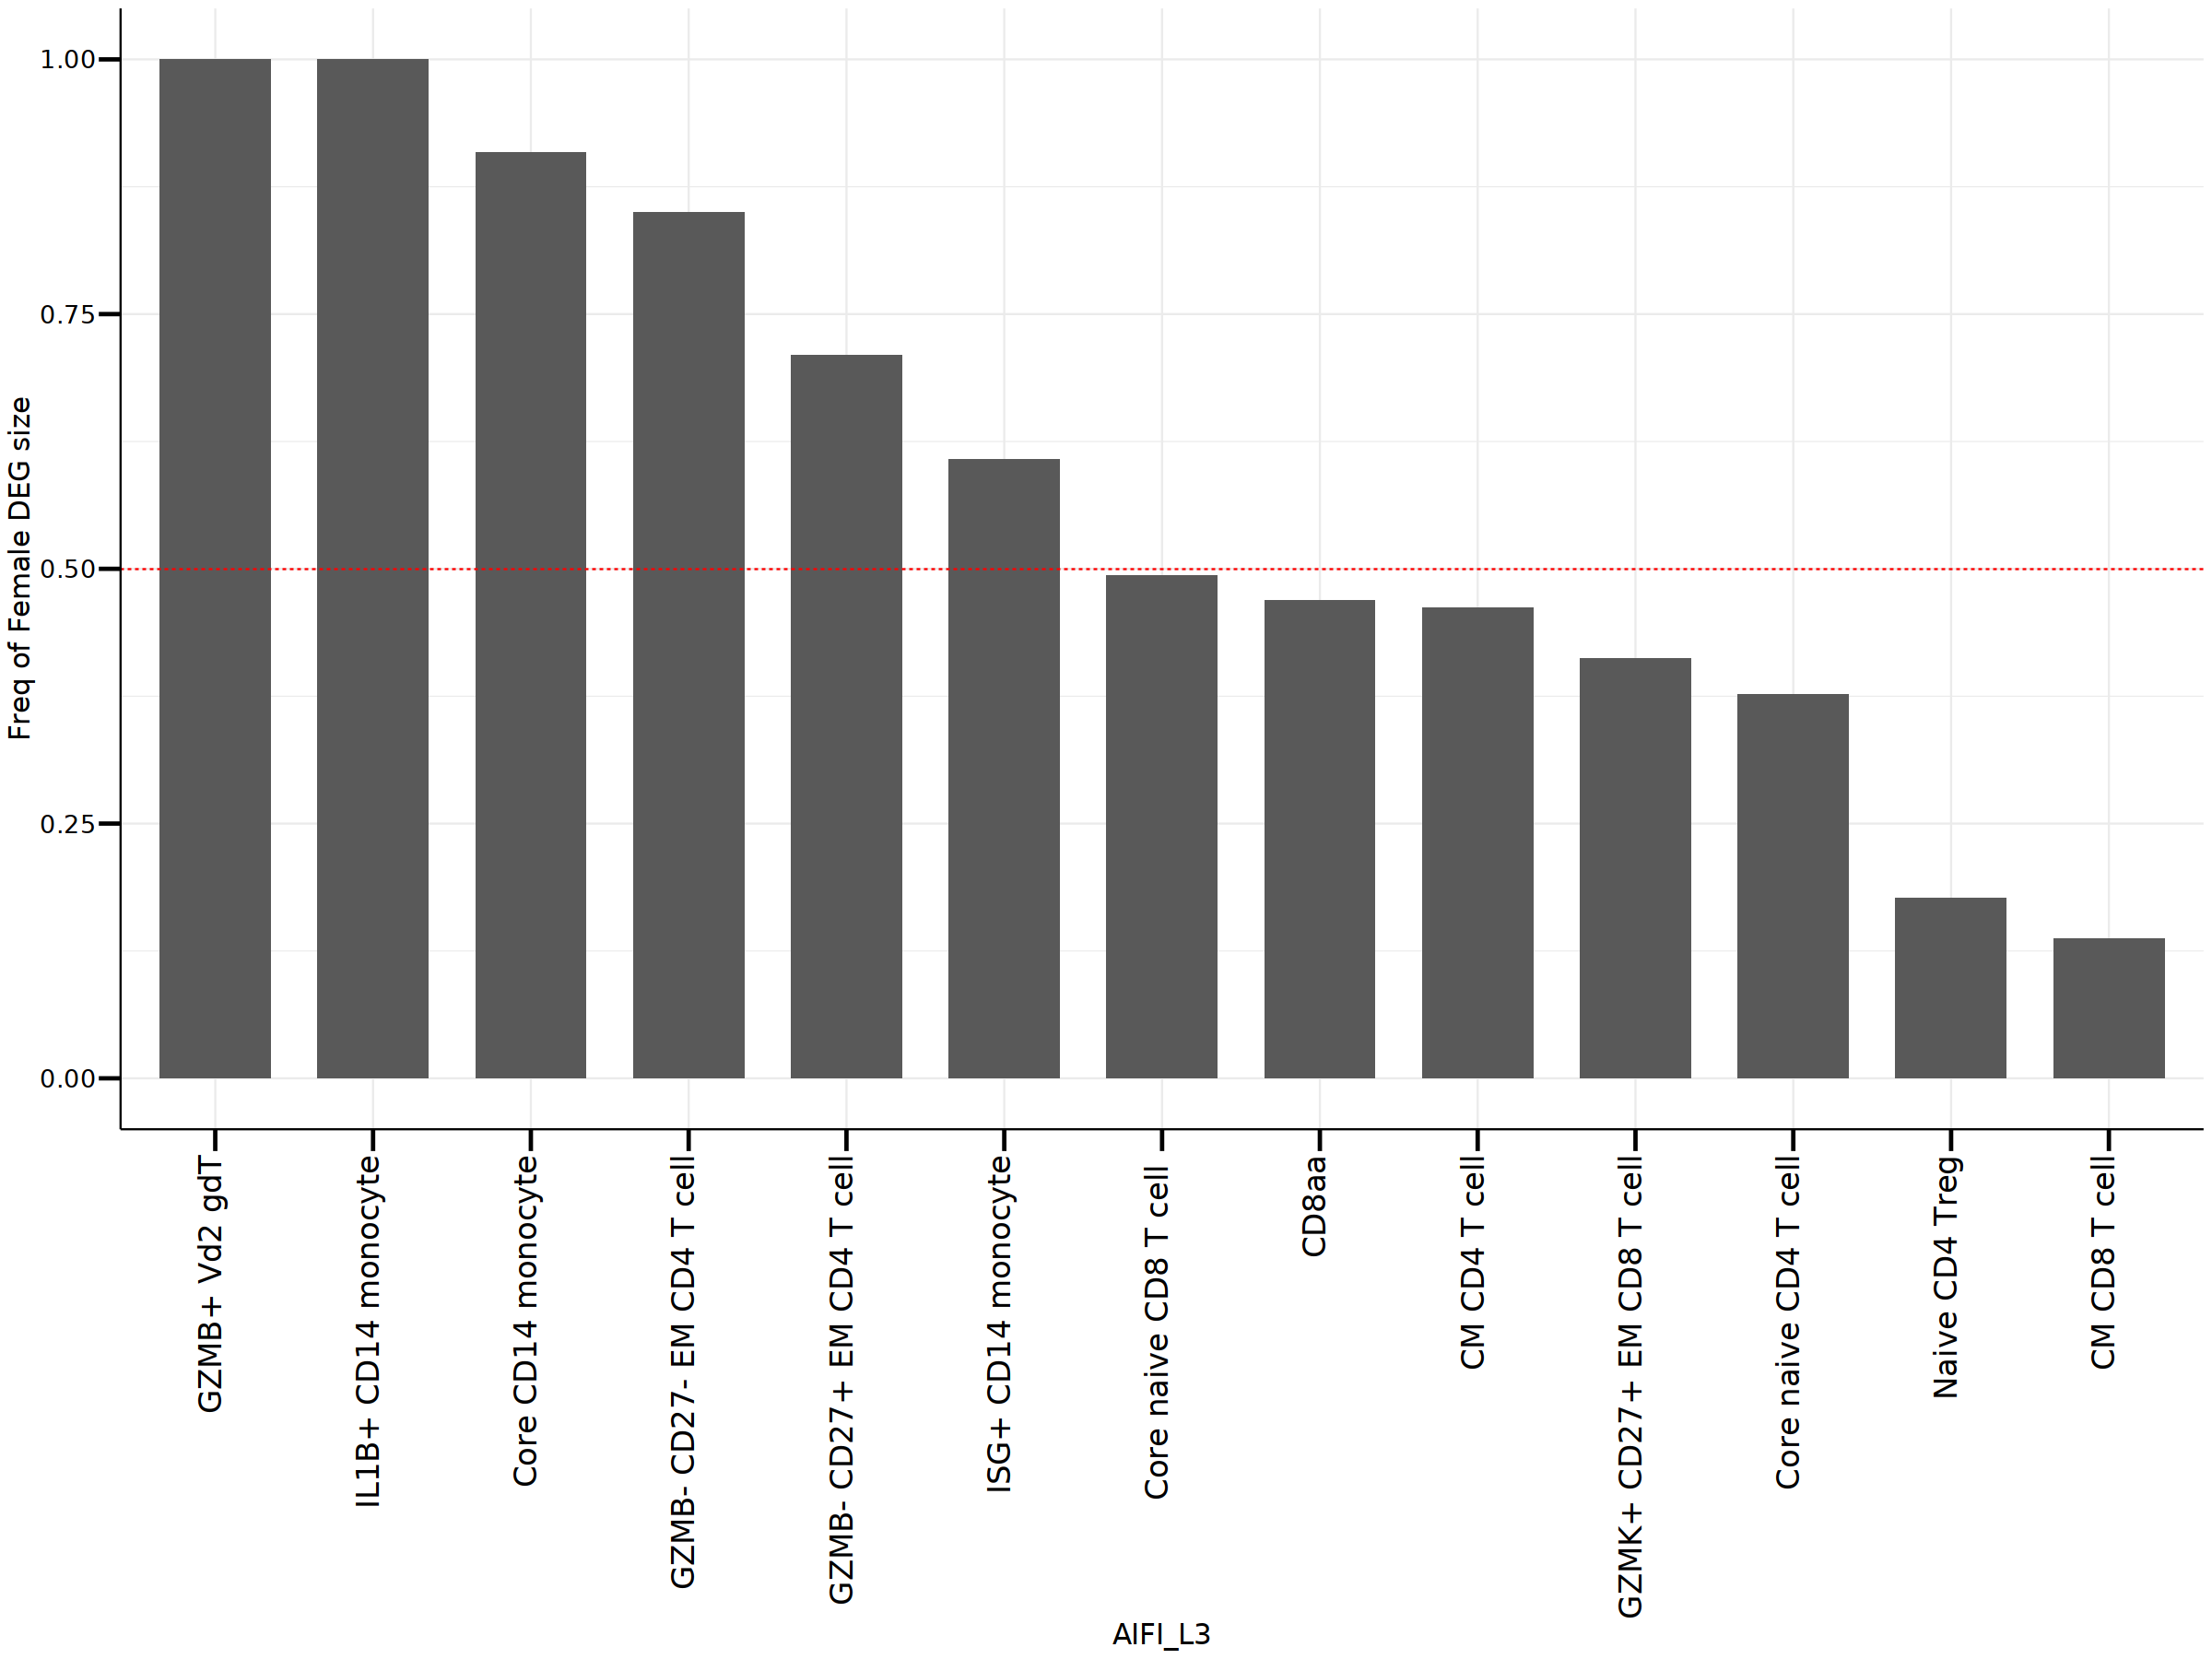

In [81]:
library(ggplot2)

# Assuming your dataframe is named df
# Replace df with the actual name of your dataframe if different

# Sort dataframe by Data_y in descending order
new_JI <- new_JI[order(-new_JI$Unique_F_ratio),]

# Convert cell_type to factor with levels arranged in descending order
new_JI$celltype <- factor(new_JI$celltype, levels = new_JI$celltype)

options(repr.plot.width = 20, repr.plot.height = 15)
# Create JI plot
JI_plot <- ggplot(new_JI, aes(x = celltype, y = Unique_F_ratio)) +
  geom_bar(stat = "identity", width = 0.7) +
  #geom_segment(aes(x = celltype, xend = celltype, y = 0, yend = Unique_F_ratio), color = "skyblue") +
  #geom_point(color = "blue", size = 3) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "red")+
  theme_minimal() + 
  #coord_flip() + 
  labs(x = "AIFI_L3", y = "Freq of Female DEG size") +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  )

# Print the plot
print(JI_plot)



In [63]:
# save the celltype order to use it on the nDEGs plot
# Specify the order of cell types
celltype_order <- new_JI$celltype

In [65]:
length(celltype_order)

[1] 13

## Stack the nDEG and JI rato plot together

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


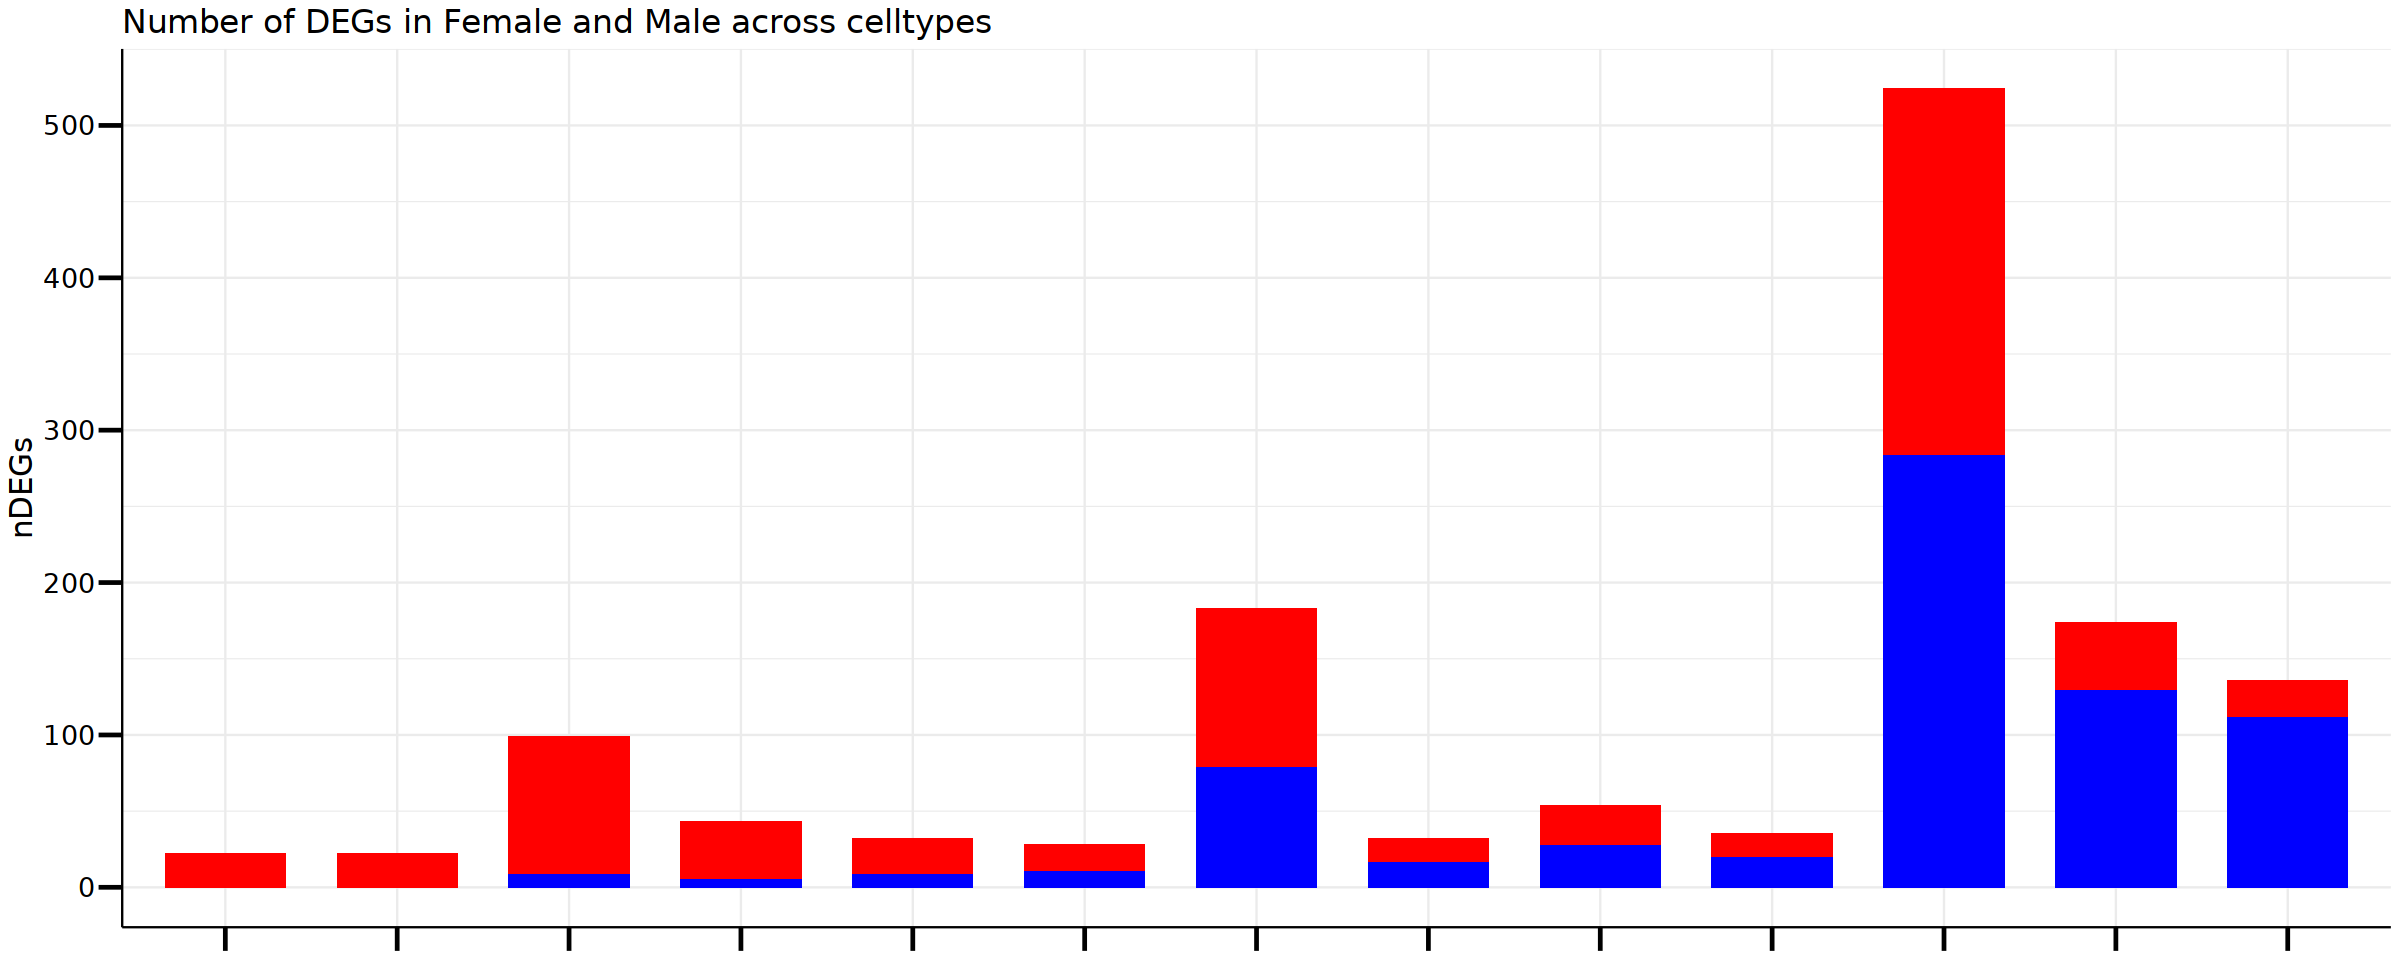

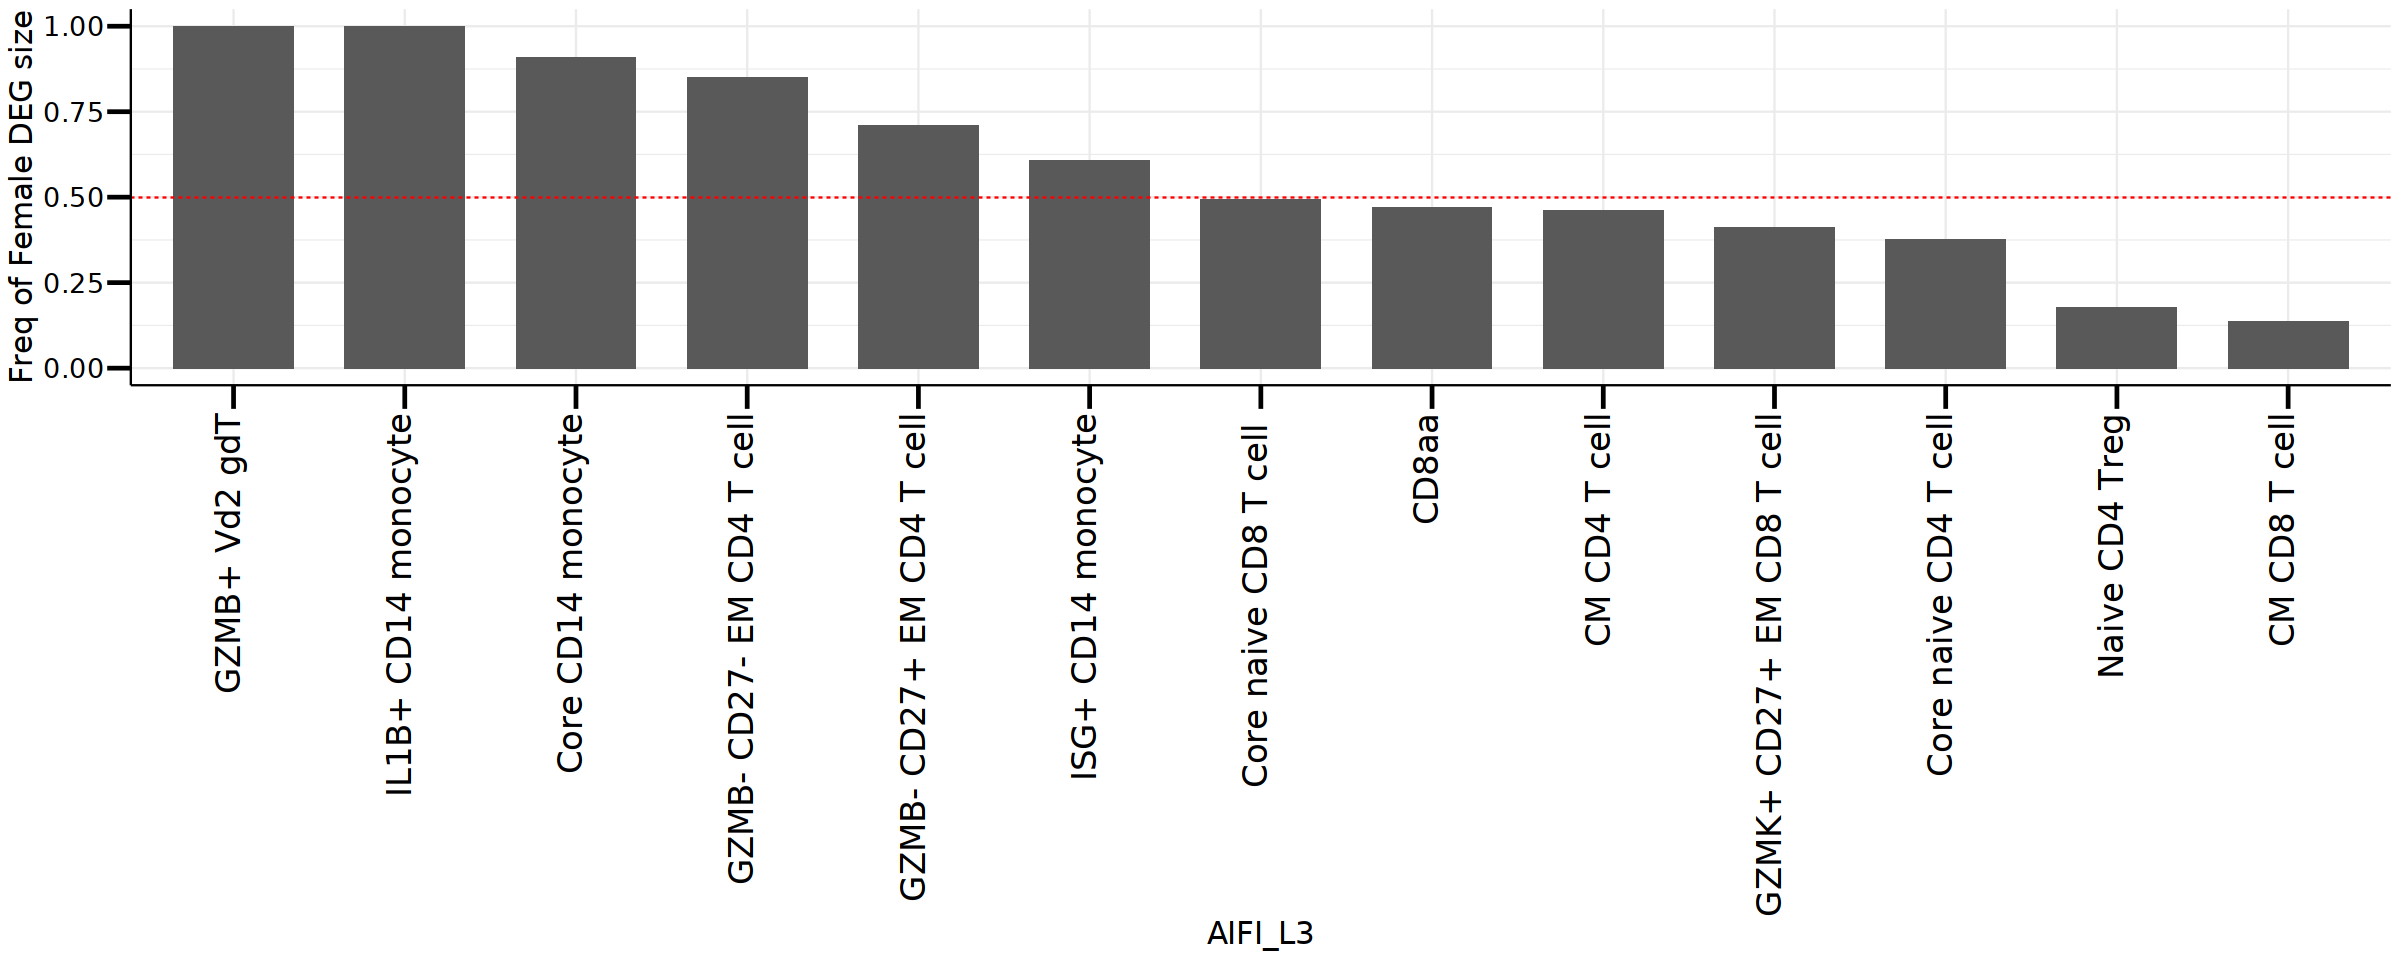

In [77]:
options(repr.plot.width = 20, repr.plot.height = 8)

# Set the same x-axis limits for both plots
x_limits <- c(1, length(celltype_order))

# Print the plots

print(nDEG_plot + coord_cartesian(xlim = x_limits))
print(JI_plot + coord_cartesian(xlim = x_limits))



In [54]:
library(ggpubr)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




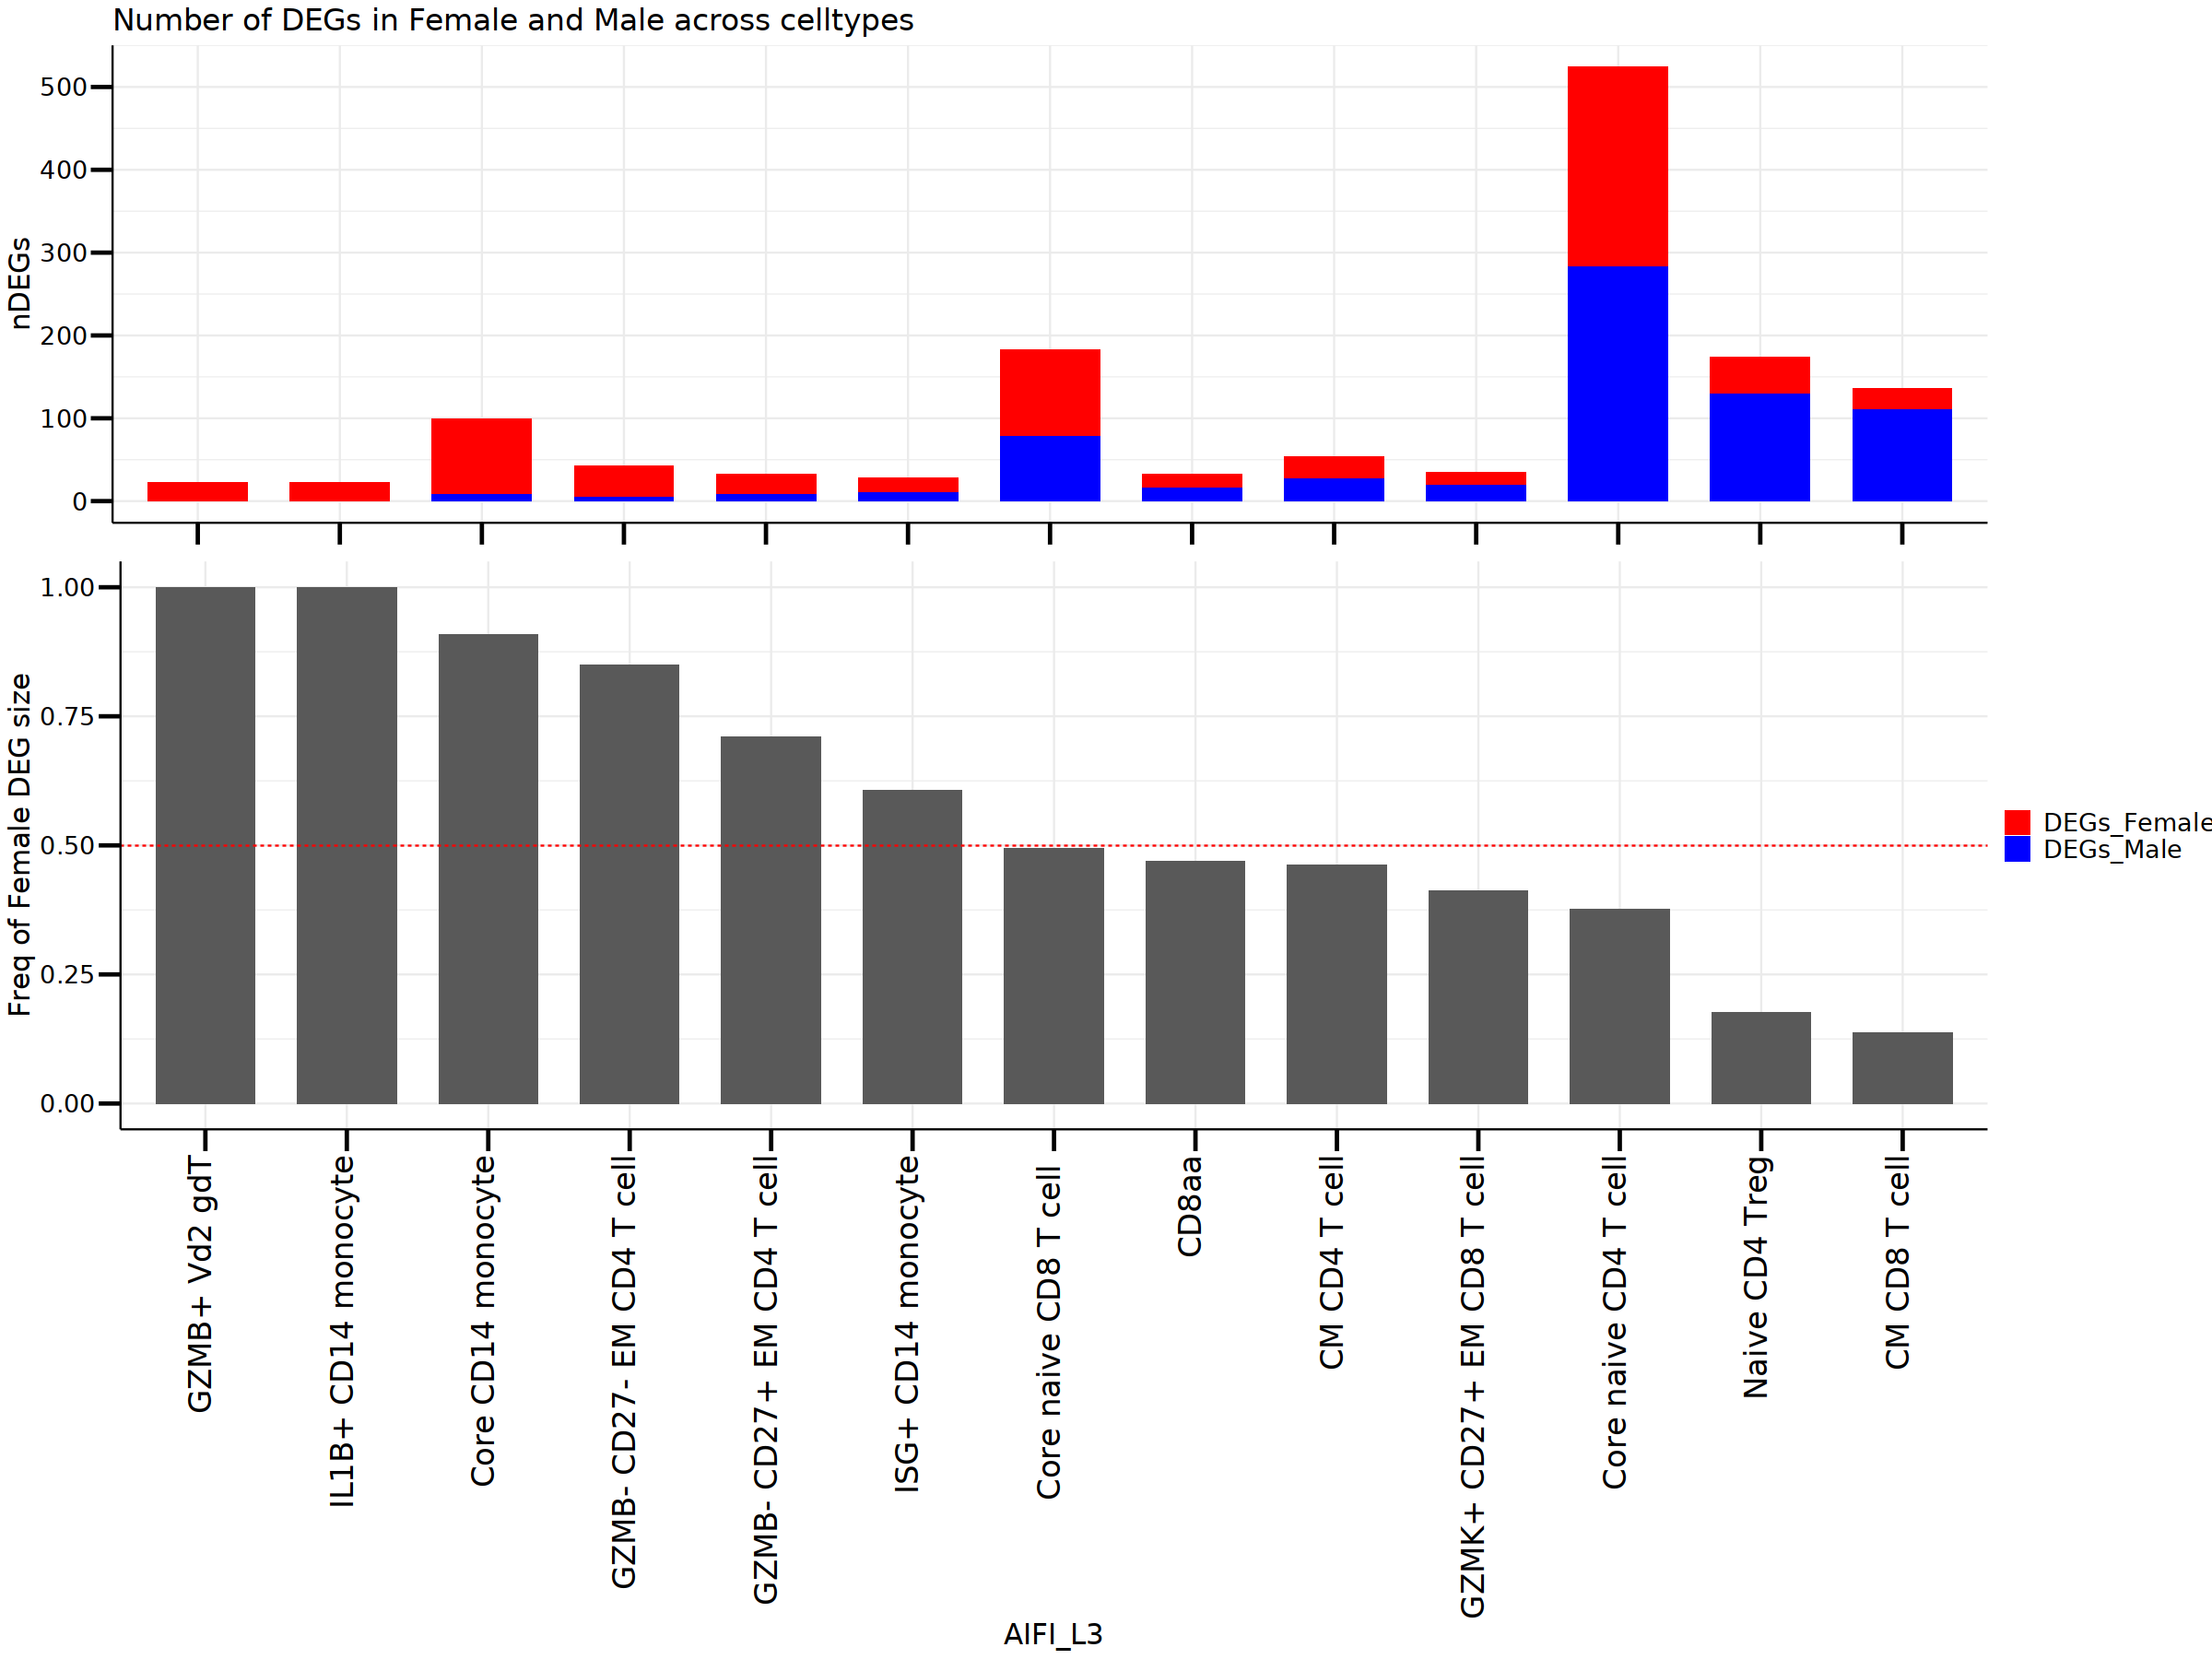

In [83]:
options(repr.plot.width = 20, repr.plot.height = 15)
ggarrange(nDEG_plot, JI_plot, nrow = 2, heights = c(1, 2), common.legend = TRUE, legend= "right")
#grid.arrange(nDEG_plot, JI_plot, ncol = 1)


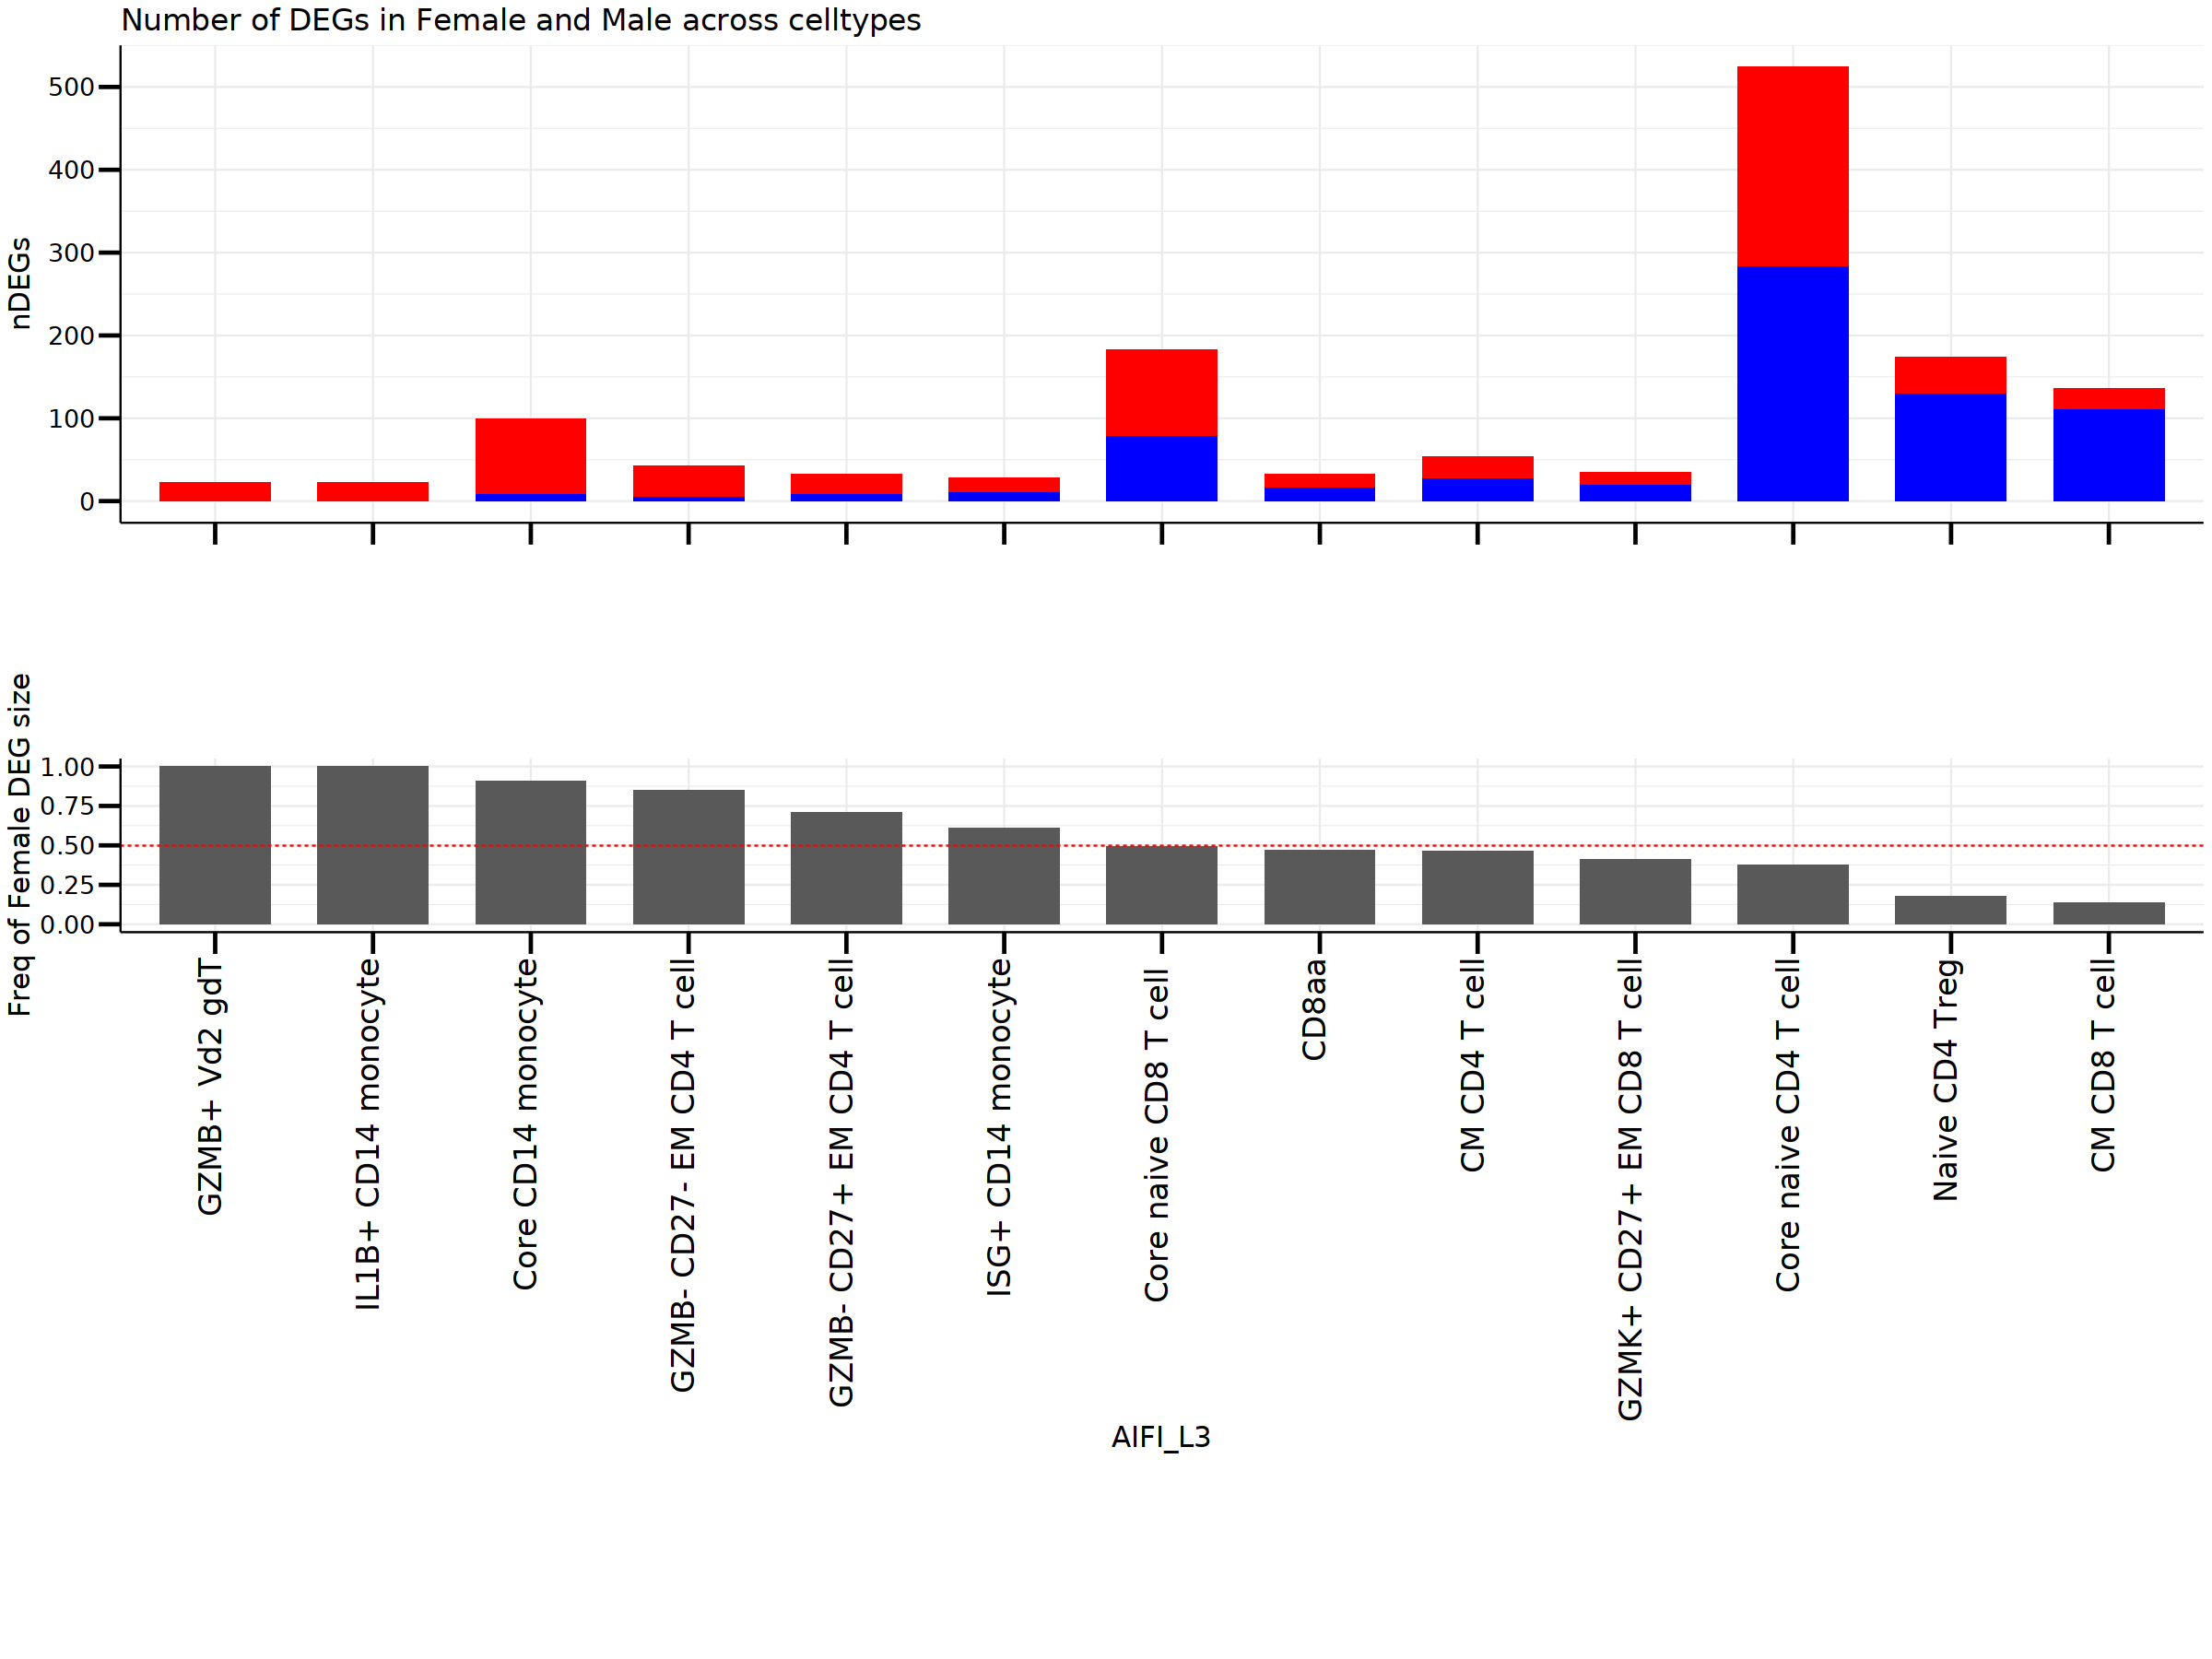

In [76]:
library(cowplot)

# Create the plots separately
plot1 <- nDEG_plot
plot2 <- JI_plot

# Combine the plots into a single grid
combined_plot <- plot_grid(plot1, plot2, nrow = 2, align = "v", rel_heights = c(1, 2))

# Print the combined plot
print(combined_plot)


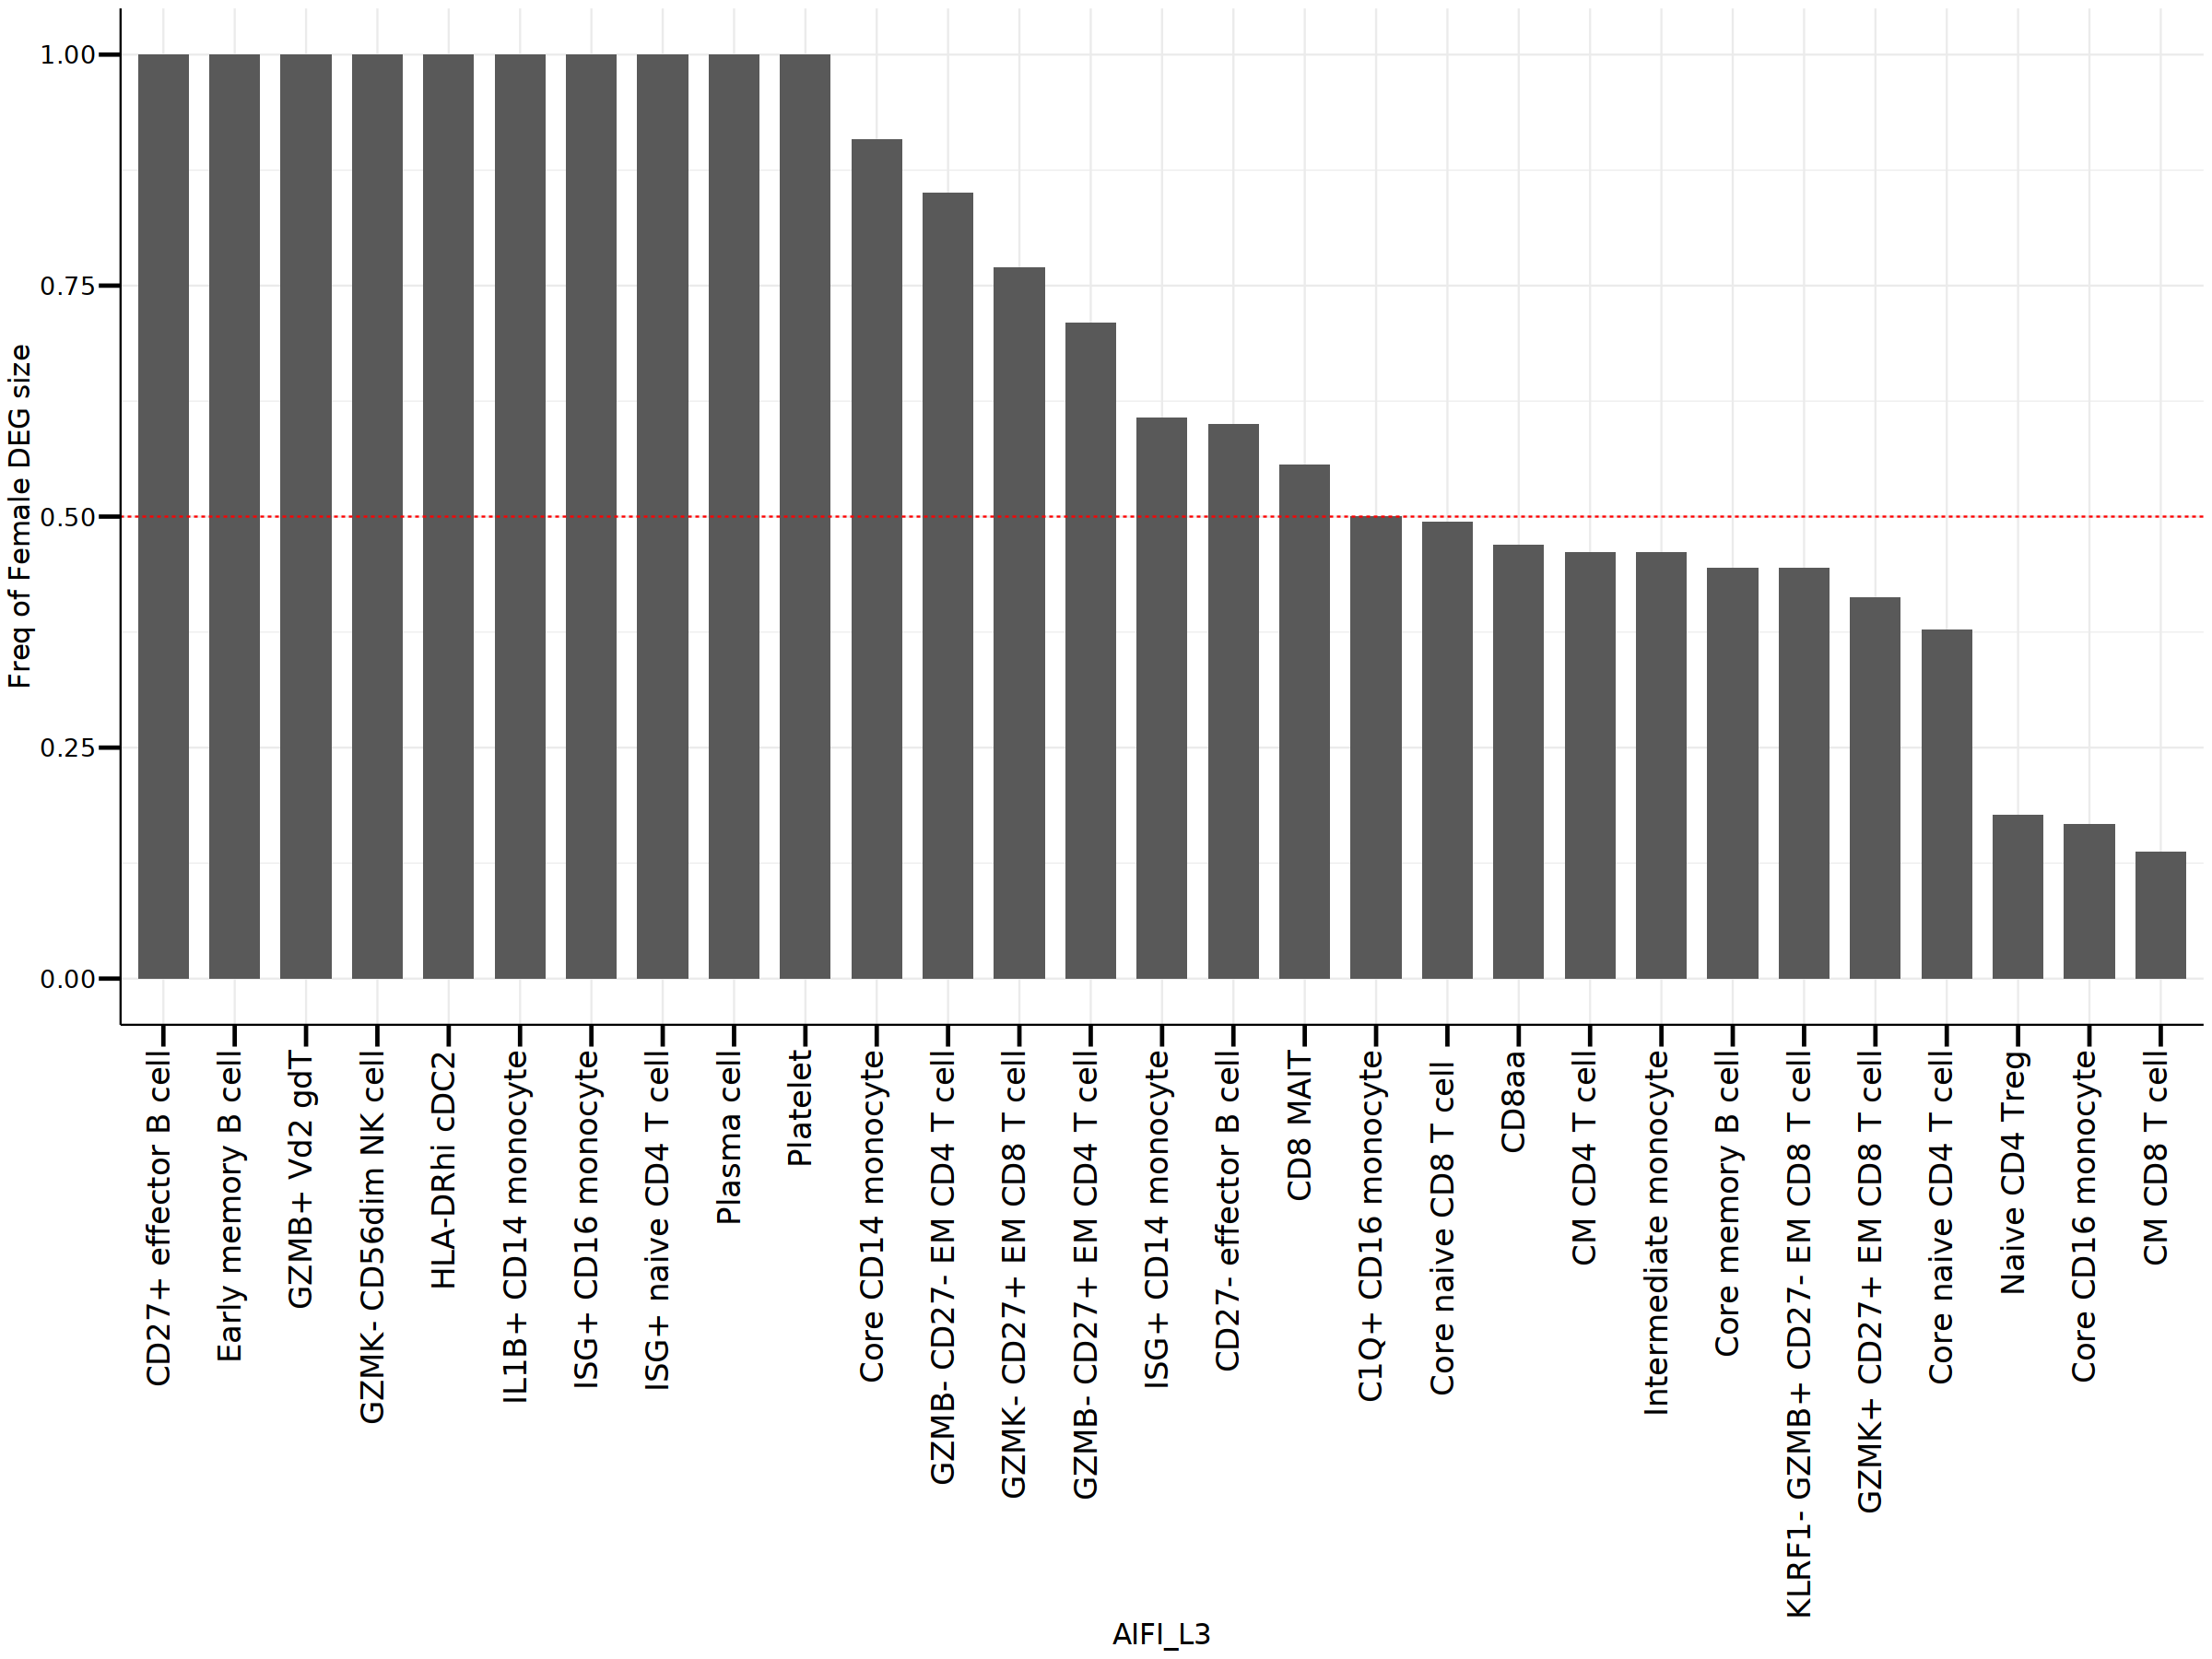

In [186]:
library(ggplot2)

# Assuming your dataframe is named df
# Replace df with the actual name of your dataframe if different

# Sort dataframe by Data_y in descending order
new_JI <- new_JI[order(-new_JI$Unique_F_ratio),]

# Convert cell_type to factor with levels arranged in descending order
new_JI$celltype <- factor(new_JI$celltype, levels = new_JI$celltype)

#options(repr.plot.width = 20, repr.plot.height = 10)
# Create JI plot
JI_plot <- ggplot(new_JI, aes(x = celltype, y = Unique_F_ratio)) +
  geom_bar(stat = "identity", width = 0.7) +
  #geom_segment(aes(x = celltype, xend = celltype, y = 0, yend = Unique_F_ratio), color = "skyblue") +
  #geom_point(color = "blue", size = 3) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "red")+
  theme_minimal() + 
  #coord_flip() + 
  labs(x = "AIFI_L3", y = "Freq of Female DEG size") +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  )   

# Print the plot
#print(JI_plot)




pastel_colors <- c( "red", "blue" )  # Example pastel colors

#celltype order from the JI plot
master_complete$celltype <- factor(master_complete$celltype, levels = celltype_order)
#reorder(celltype, desc(count))
#options(repr.plot.width = 20, repr.plot.height = 5)

nDEG_plot <- ggplot(master_complete, aes(x = celltype, y = count, fill = type)) +
  geom_bar(stat = "identity", width = 0.7) +
  scale_fill_manual(values = pastel_colors) +  # Set pastel colors
  labs(title = "Number of DEGs in Female and Male across celltypes", x = "\nAIFI_L3", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  ) +
  theme(axis.title.x = element_blank(), axis.text.x = element_blank()) + theme(legend.position = "none")

#nDEG_plot



options(repr.plot.width = 20, repr.plot.height = 15)
ggarrange(nDEG_plot, JI_plot, nrow = 2, heights = c(1, 2), align = "v", common.legend = TRUE, legend= "right")


Warning message in as_grob.default(plot):
“Cannot convert object of class logical into a grob.”
Warning message in as_grob.default(plot):
“Cannot convert object of class character into a grob.”


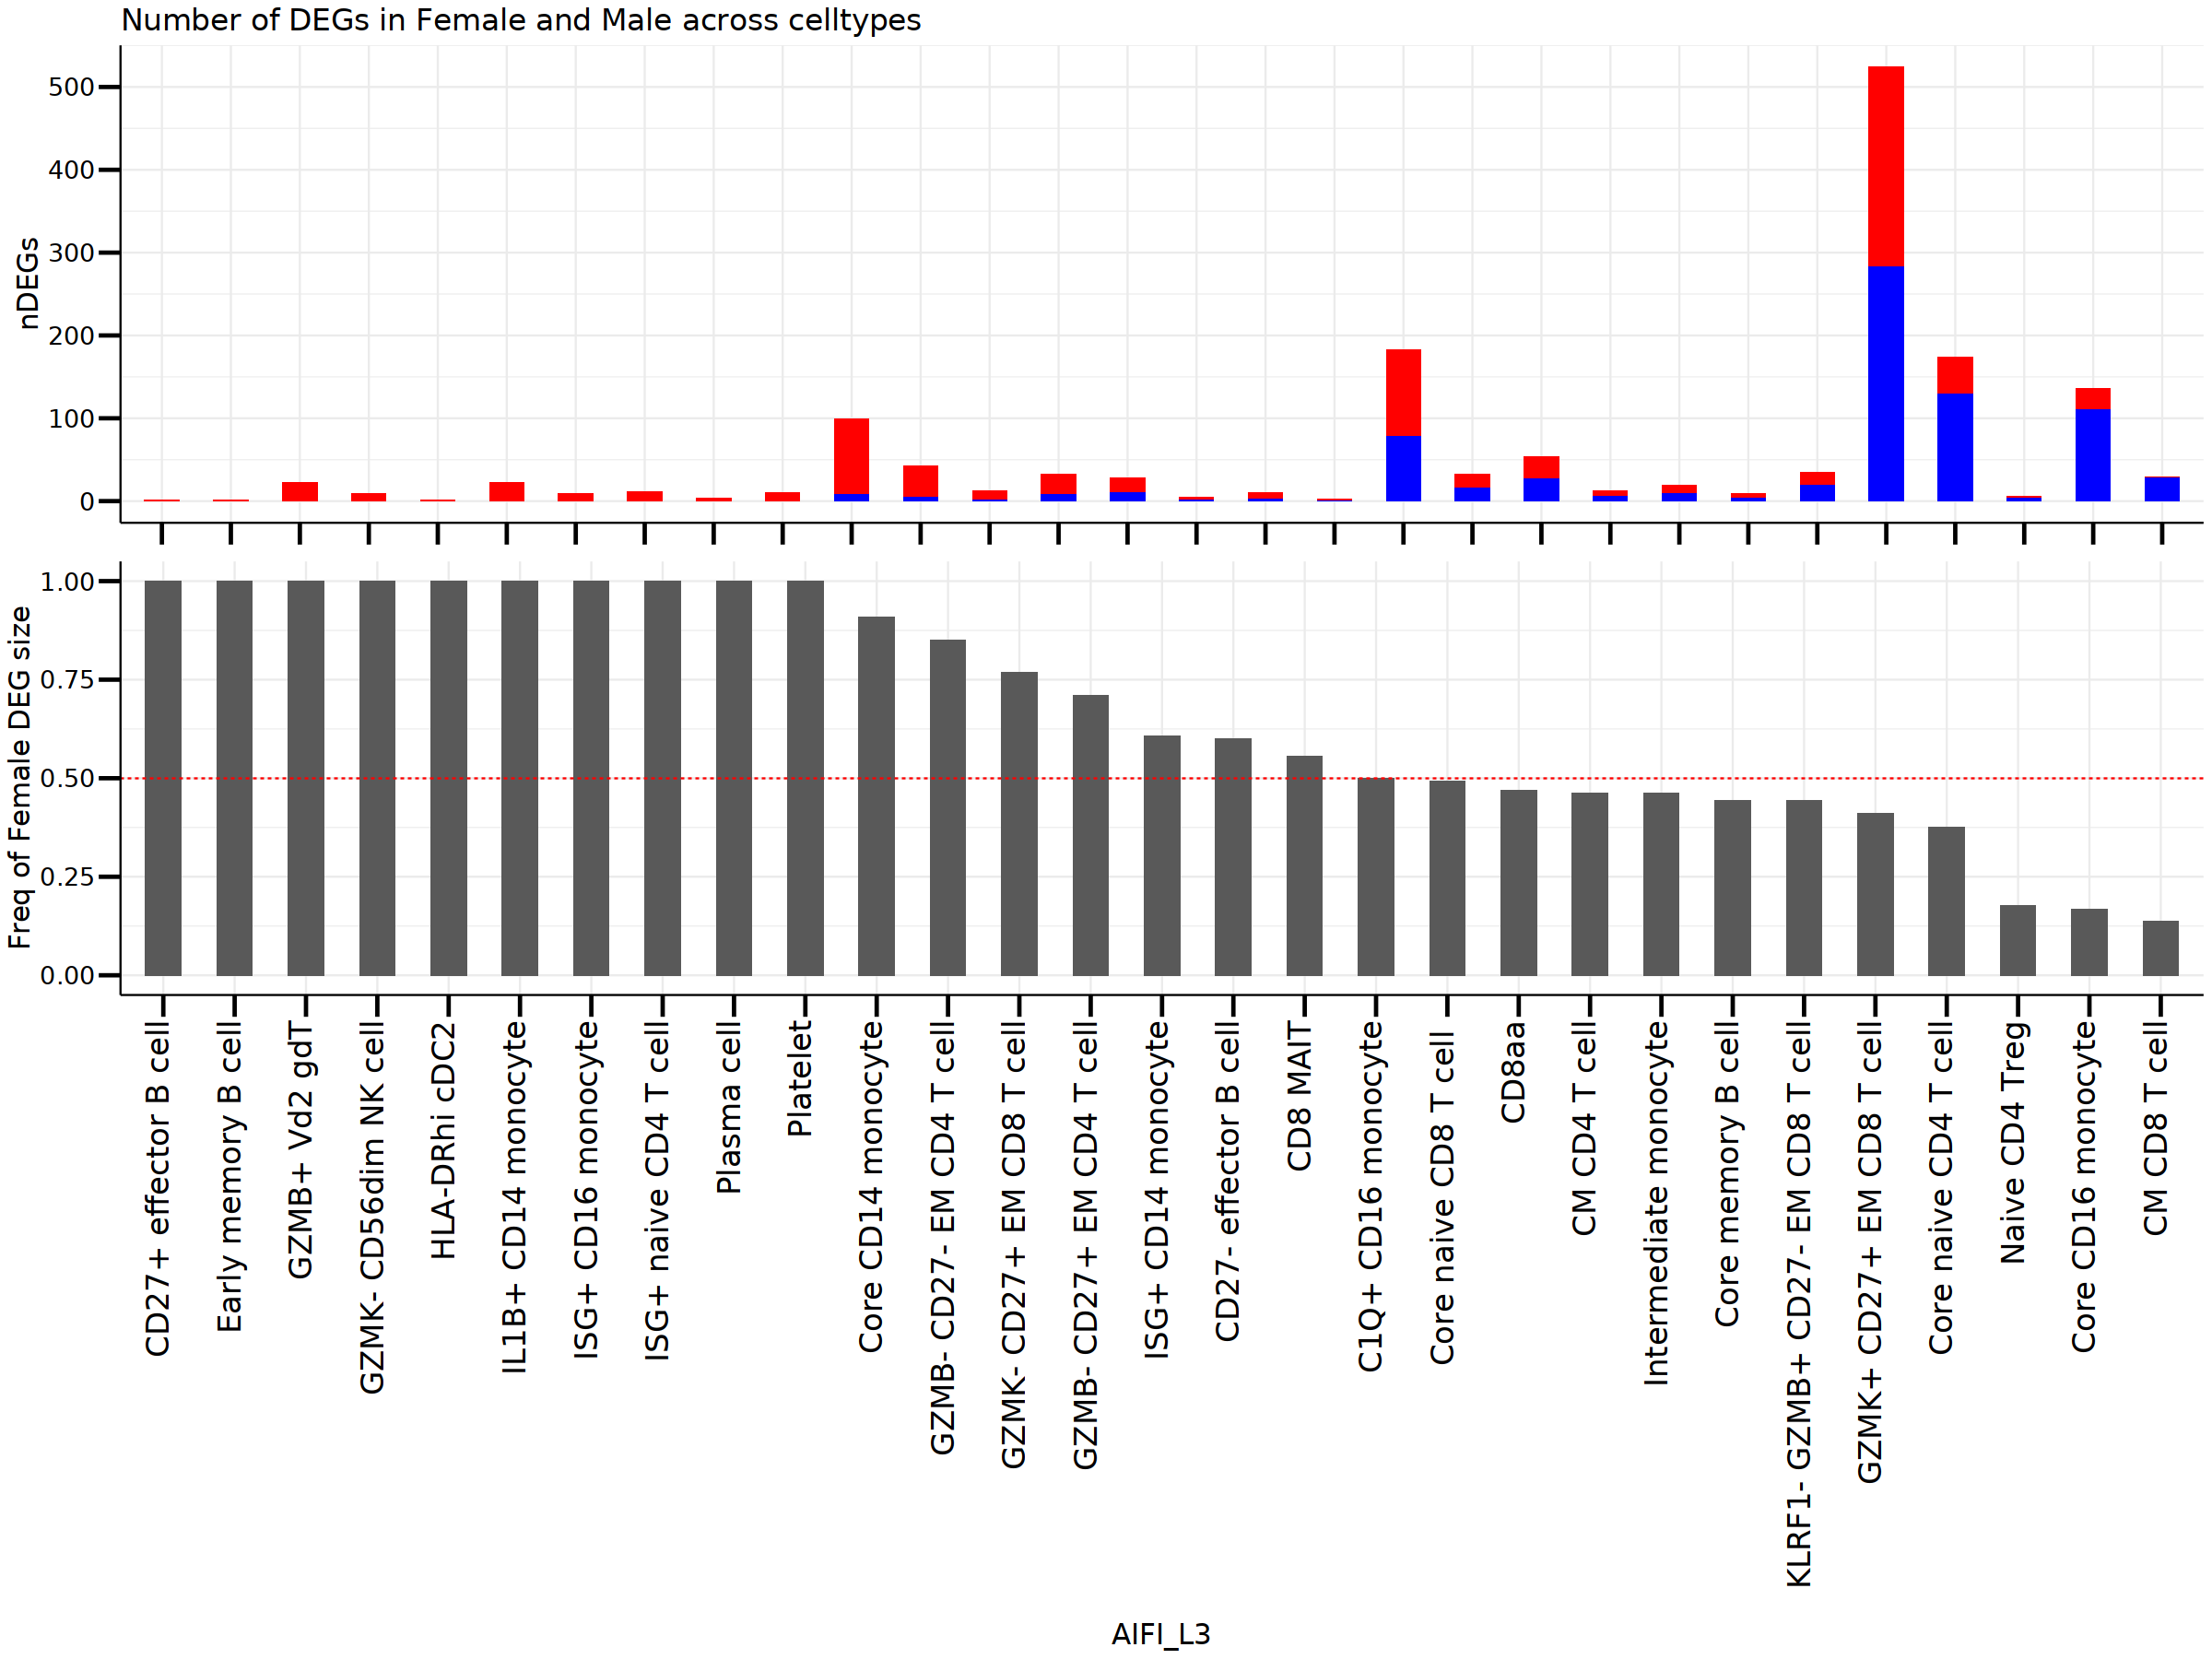

In [215]:
library(ggplot2)
library(cowplot)

# Assuming your dataframe is named df
# Replace df with the actual name of your dataframe if different

# Sort dataframe by Data_y in descending order
new_JI <- new_JI[order(-new_JI$Unique_F_ratio),]

# Convert cell_type to factor with levels arranged in descending order
new_JI$celltype <- factor(new_JI$celltype, levels = new_JI$celltype)

# Get the celltype order
celltype_order <- unique(new_JI$celltype)

# Plot 1: JI Plot
JI_plot <- ggplot(new_JI, aes(x = factor(celltype, levels = celltype_order), y = Unique_F_ratio)) +
  geom_bar(stat = "identity", width = 0.5) +  # Adjust width
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "red") +
  theme_minimal() + 
  labs(x = "\nAIFI_L3", y = "Freq of Female DEG size") +
  theme(
    text = element_text(size = 16, color = "black"),
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),
    legend.title = element_blank(),
    legend.text = element_text(size = 16),
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", size = 0.5, linewidth = "solid"),
    axis.ticks.length  = unit(0.5, "cm")
  ) 

# Plot 2: nDEG Plot
pastel_colors <- c("red", "blue")  # Example pastel colors

nDEG_plot <- ggplot(master_complete, aes(x = factor(celltype, levels = celltype_order), y = count, fill = type)) +
  geom_bar(stat = "identity", width = 0.5) +  # Adjust width
  scale_fill_manual(values = pastel_colors) +
  labs(title = "Number of DEGs in Female and Male across celltypes", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),
    legend.title = element_blank(),
    legend.text = element_text(size = 16),
    axis.ticks = element_line(color = 1, linewidth = 1),
    axis.line = element_line(colour = "black", size = 0.5, linewidth = "solid"),
    axis.ticks.length  = unit(0.5, "cm")
  ) +
  theme(axis.title.x = element_blank(), axis.text.x = element_blank(), legend.position = "none")

# Adjust plot heights
options(repr.plot.width = 20, repr.plot.height = 15)

# Arrange plots vertically with proper alignment
plot_grid( nDEG_plot,JI_plot, align = "v", axis = "l", nrow = 2, ncol=1, rel_heights = c(1, 2), common.legend = TRUE, legend = "right")


In [188]:
library(gridExtra)

# Create the ratio plot using JI file (padj <0.05)

In [95]:
J_index <- read.csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/Figure_Notebooks/Intermediate_files/Jaccard_index_df_FvsM_each_celltype_padj0.05.csv")

In [96]:
#J_index

In [97]:
#Use DEG# in female/ DEG# (Female+Male-shared) on Y-axis and rank from high to low 
#     in X-axis in cell types that  have total DEGs # (f+M-s) > 10

In [98]:
J_index_modi <- J_index %>%
  mutate(Union = total_DEGs_female + total_DEGs_male - common_DEGs,
         Ratio_union = total_DEGs_female / Union,
        Unique_F_ratio = (total_DEGs_female-common_DEGs)/ Union)
         

# Print the updated dataframe
head(J_index_modi)


,X,celltype,jaccard_similarity,total_DEGs_male,total_DEGs_female,common_DEGs,Union,Ratio_union,Unique_F_ratio
,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,1,Activated memory B cell,NA,0,0,0,0,NaN,NaN
2,2,Adaptive NK cell,NA,0,0,0,0,NaN,NaN
3,3,ASDC,NA,0,0,0,0,NaN,NaN
4,4,BaEoMaP cell,NA,0,0,0,0,NaN,NaN
5,5,C1Q+ CD16 monocyte,NA,0,0,0,0,NaN,NaN
6,6,CD14+ cDC2,NA,0,0,0,0,NaN,NaN


In [99]:
new_JI <- J_index_modi %>% filter(J_index_modi$Union > 10)
head(new_JI)
length(new_JI$celltype)
# new_JI <- J_index_modi
# head(new_JI)

,X,celltype,jaccard_similarity,total_DEGs_male,total_DEGs_female,common_DEGs,Union,Ratio_union,Unique_F_ratio
,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,12,CD8aa,0.00000000,6,10,0,16,0.6250000,0.6250000
2,16,CM CD4 T cell,0.05882353,6,12,1,17,0.7058824,0.6470588
3,17,CM CD8 T cell,0.06779661,50,13,4,59,0.2203390,0.1525424
4,19,Core CD14 monocyte,0.00000000,2,37,0,39,0.9487179,0.9487179
5,23,Core naive CD4 T cell,0.16666667,172,178,50,300,0.5933333,0.4266667
6,24,Core naive CD8 T cell,0.17241379,34,68,15,87,0.7816092,0.6091954


[1] 11

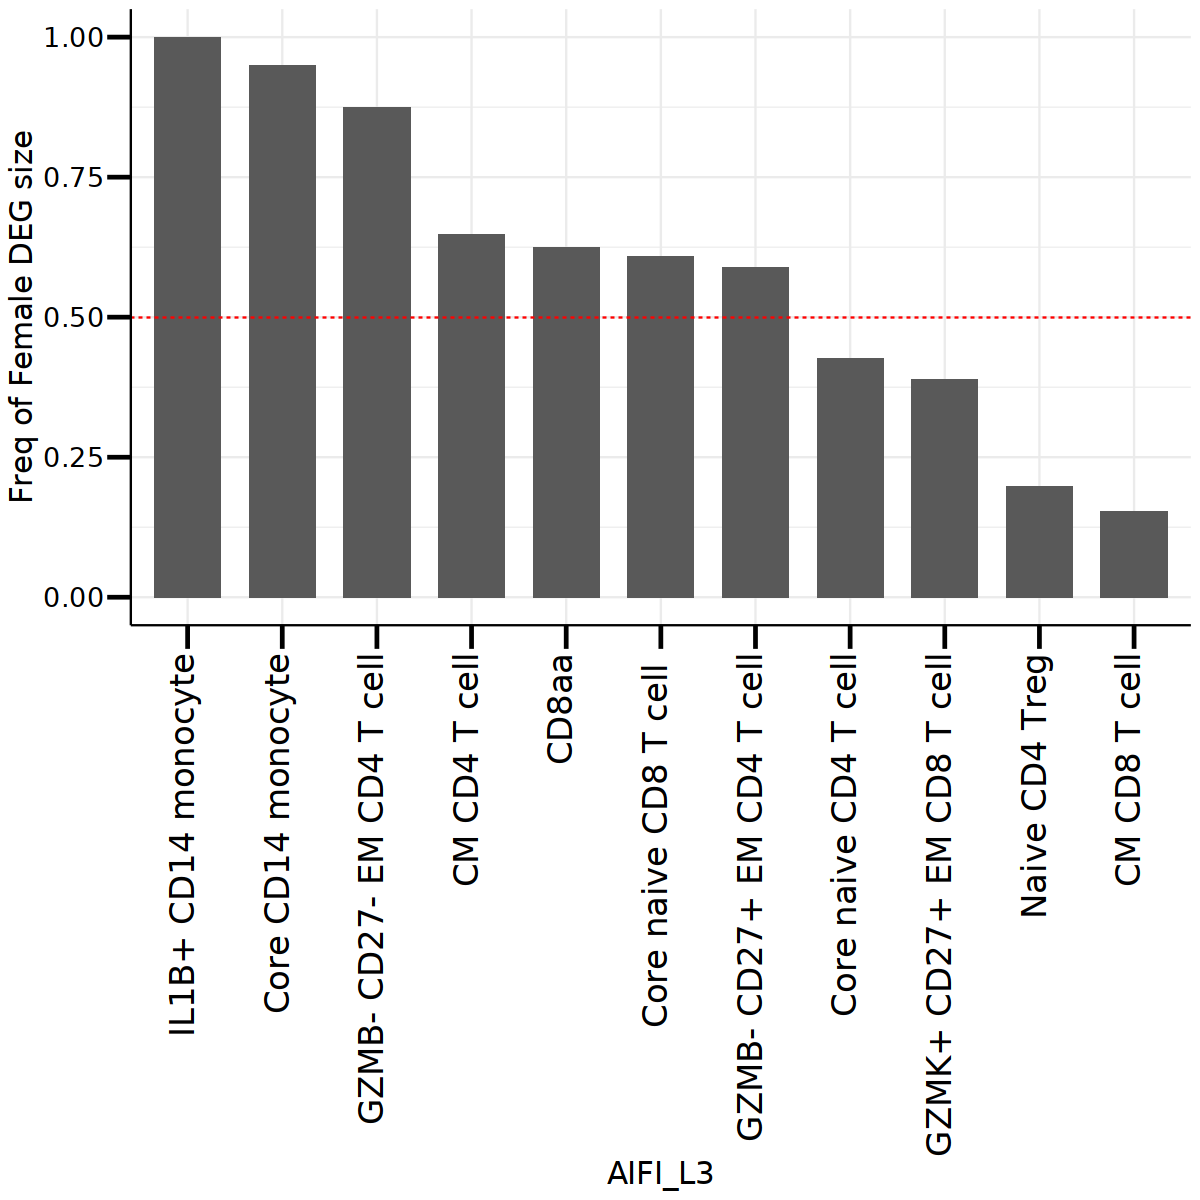

In [100]:
library(ggplot2)

# Assuming your dataframe is named df
# Replace df with the actual name of your dataframe if different

# Sort dataframe by Data_y in descending order
new_JI <- new_JI[order(-new_JI$Unique_F_ratio),]

# Convert cell_type to factor with levels arranged in descending order
new_JI$celltype <- factor(new_JI$celltype, levels = new_JI$celltype)

options(repr.plot.width = 10, repr.plot.height = 10)
# Create lollipop plot
lollipop_plot <- ggplot(new_JI, aes(x = celltype, y = Unique_F_ratio)) +
  geom_bar(stat = "identity", width = 0.7) +
  #geom_segment(aes(x = celltype, xend = celltype, y = 0, yend = Unique_F_ratio), color = "skyblue") +
  #geom_point(color = "blue", size = 3) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "red")+
  theme_minimal() + 
  #coord_flip() + 
  labs(x = "AIFI_L3", y = "Freq of Female DEG size") +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  )   

# Print the plot
print(lollipop_plot)

